# Regression Analyses (work in progress--more code and much more documentation to come)

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
e = create_engine('sqlite:///../Appendix/nvcu_db.db')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import plotly.express as px
from statsmodels.stats.weightstats import ttest_ind

import sys
sys.path.insert(1, '../Appendix')
from helper_funcs import config_notebook, wadi
display_type = config_notebook(display_max_columns = 7,
                              display_max_rows = 8)
df_survey_results = pd.read_csv(
    '../Data_Prep/2023_survey_results.csv')


In [2]:
# Creating a table of fall and spring bookstore sale totals for each 
# student:
# This will be based on the student demographics table, as 
# certain demographic items will play a role in students' spring 
# purchase totals.
df_sales = pd.read_sql(
    "select student_id, gender, college, level from \
curr_enrollment", con = e)
enrollment = len(df_sales)
df_sales

student_id gender college level
0         2020-1      F     STC    Fr
1         2020-2      F     STM    Fr
2         2020-3      F     STC    Fr
3         2020-4      F     STC    Fr
...          ...    ...     ...   ...
16380  2023-5440      M     STM    Se
16381  2023-5441      M     STL    Se
16382  2023-5442      M     STB    Se
16383  2023-5443      M     STM    Se

[16384 rows x 4 columns]

## Creating a new bookstore sales table that will ultimately get incorporated into the Appendix:

In [3]:
rng = np.random.default_rng(seed = 225403)
df_sales['Fall'] = rng.normal(
    loc = 80, scale = 25, size = len(df_sales))

# spring_change = 3 + (rng.random(size = 1000)) * -6
spring_change = rng.normal(loc = 11, scale = 25, size = len(df_sales))
df_sales['Spring'] = df_sales['Fall'] + spring_change
# Modifying Spring totals based on demographic components:
spring_col = df_sales.columns.get_loc('Spring')
for i in range(len(df_sales)):
    # Unhealthy snacks were removed from the checkout aisle; 
    # this ended up reducing revenue among freshmen and sophomore
    # (who particularly liked these snacks)
    if df_sales.iloc[i]['level'] in ['Fr', 'So']:
        df_sales.iloc[i, spring_col] = (
            df_sales.iloc[i, spring_col] + rng.normal(
                loc = -21, scale = 3))
    # An intensive marketing campaign was carried out at STM and STL;
    # if it ended up being successful, it would then be implemented
    # at the other colleges also.
    if df_sales.iloc[i]['college'] in ['STM', 'STL']:
        df_sales.iloc[i, spring_col] = (
            df_sales.iloc[i, spring_col] + rng.normal(
                loc = 9, scale = 3))

# I'll leave in negative Fall and Spring values, as they could be 
# explained by refunds.

df_sales['Fall'] = df_sales['Fall'].round(2)
df_sales['Spring'] = df_sales['Spring'].round(2)
df_sales['Fall_Spring_Change'] = df_sales['Spring'] - df_sales['Fall']

df_sales

student_id gender college level    Fall  Spring  Fall_Spring_Change
0         2020-1      F     STC    Fr   66.80   43.20              -23.60
1         2020-2      F     STM    Fr  104.67  130.17               25.50
2         2020-3      F     STC    Fr   46.17   -8.95              -55.12
3         2020-4      F     STC    Fr   58.68   53.95               -4.73
...          ...    ...     ...   ...     ...     ...                 ...
16380  2023-5440      M     STM    Se   59.95   67.11                7.16
16381  2023-5441      M     STL    Se   71.57   65.04               -6.53
16382  2023-5442      M     STB    Se  100.52   61.14              -39.38
16383  2023-5443      M     STM    Se   57.45   62.86                5.41

[16384 rows x 7 columns]

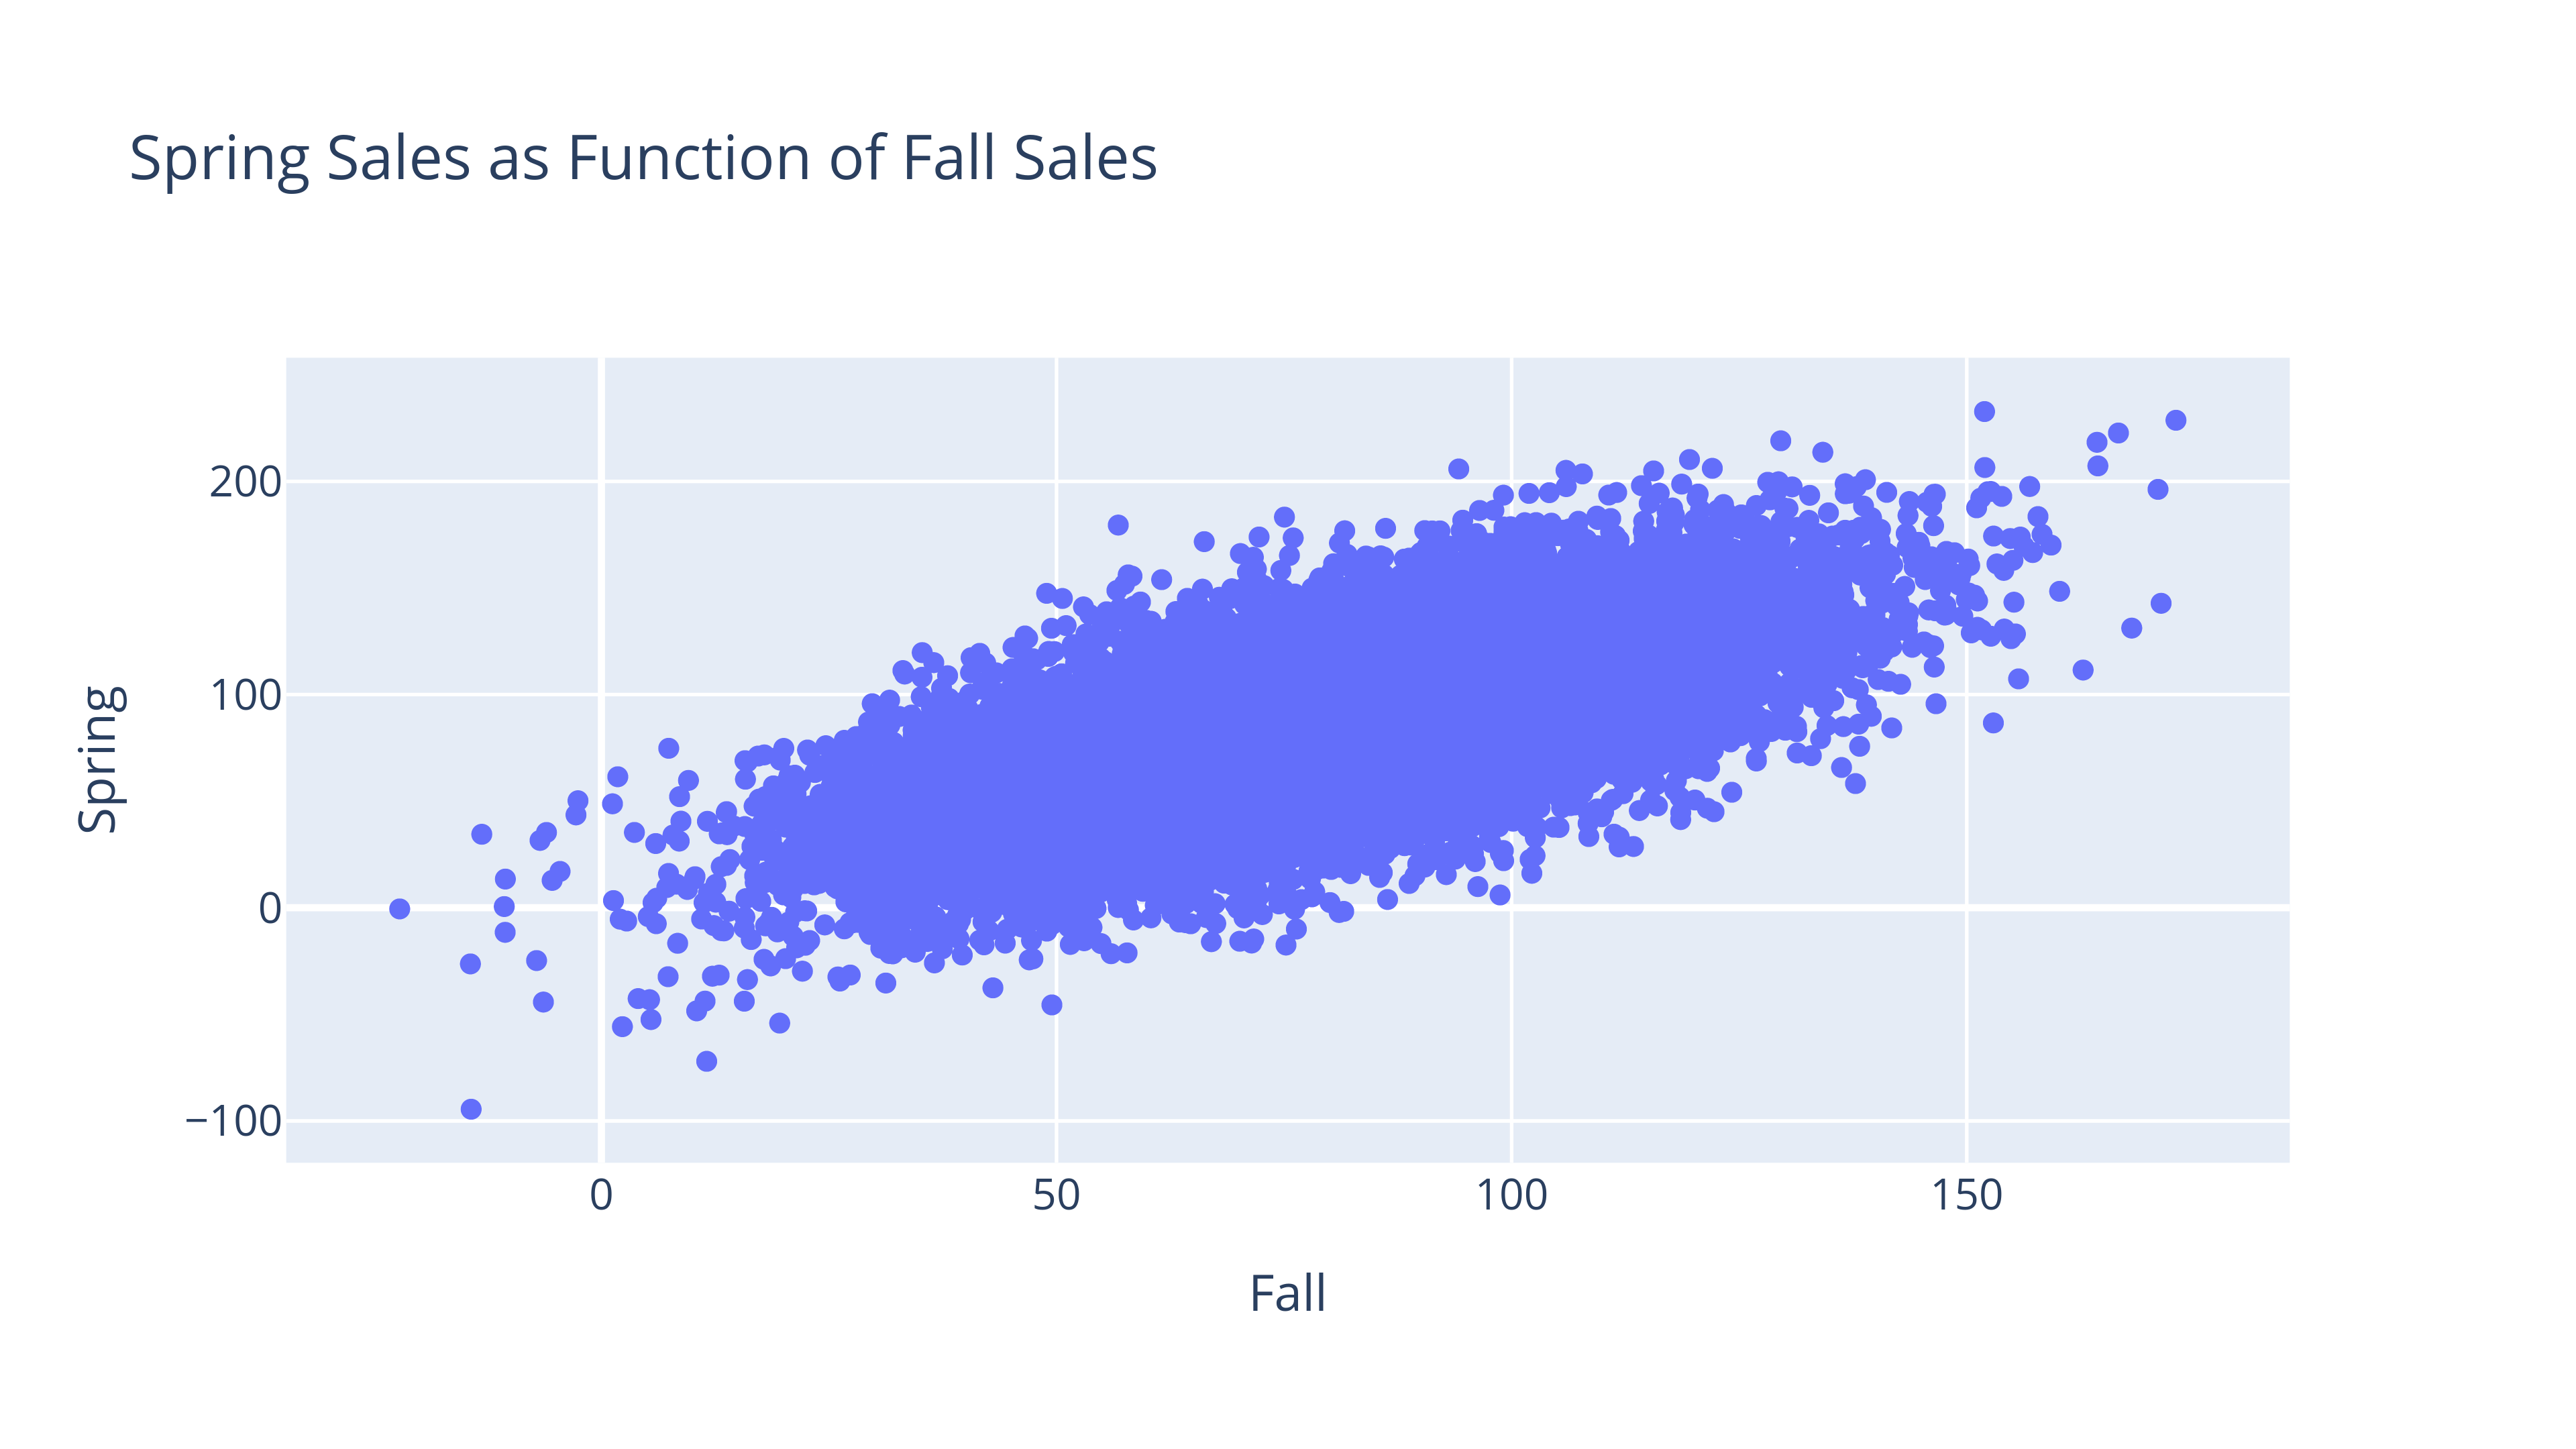

In [77]:
fig_fall_spring_sales_scatter = px.scatter(
    df_sales, x = 'Fall', y = 'Spring',
title = 'Spring Sales as Function of Fall Sales')
wadi(fig_fall_spring_sales_scatter, 
     'Charts/fall_spring_sales_scatter', display_type = display_type)

In [5]:
df_sales_pivot = df_sales.pivot_table(
    index = ['college', 'level'], values = 'Fall_Spring_Change', 
    aggfunc = 'mean').reset_index()
df_sales_pivot

college level  Fall_Spring_Change
0      STB    Fr           -8.593388
1      STB    Ju           10.325600
2      STB    Se           10.594156
3      STB    So          -10.309651
..     ...   ...                 ...
12     STM    Fr           -1.771867
13     STM    Ju           20.136222
14     STM    Se           20.104400
15     STM    So           -0.919191

[16 rows x 3 columns]

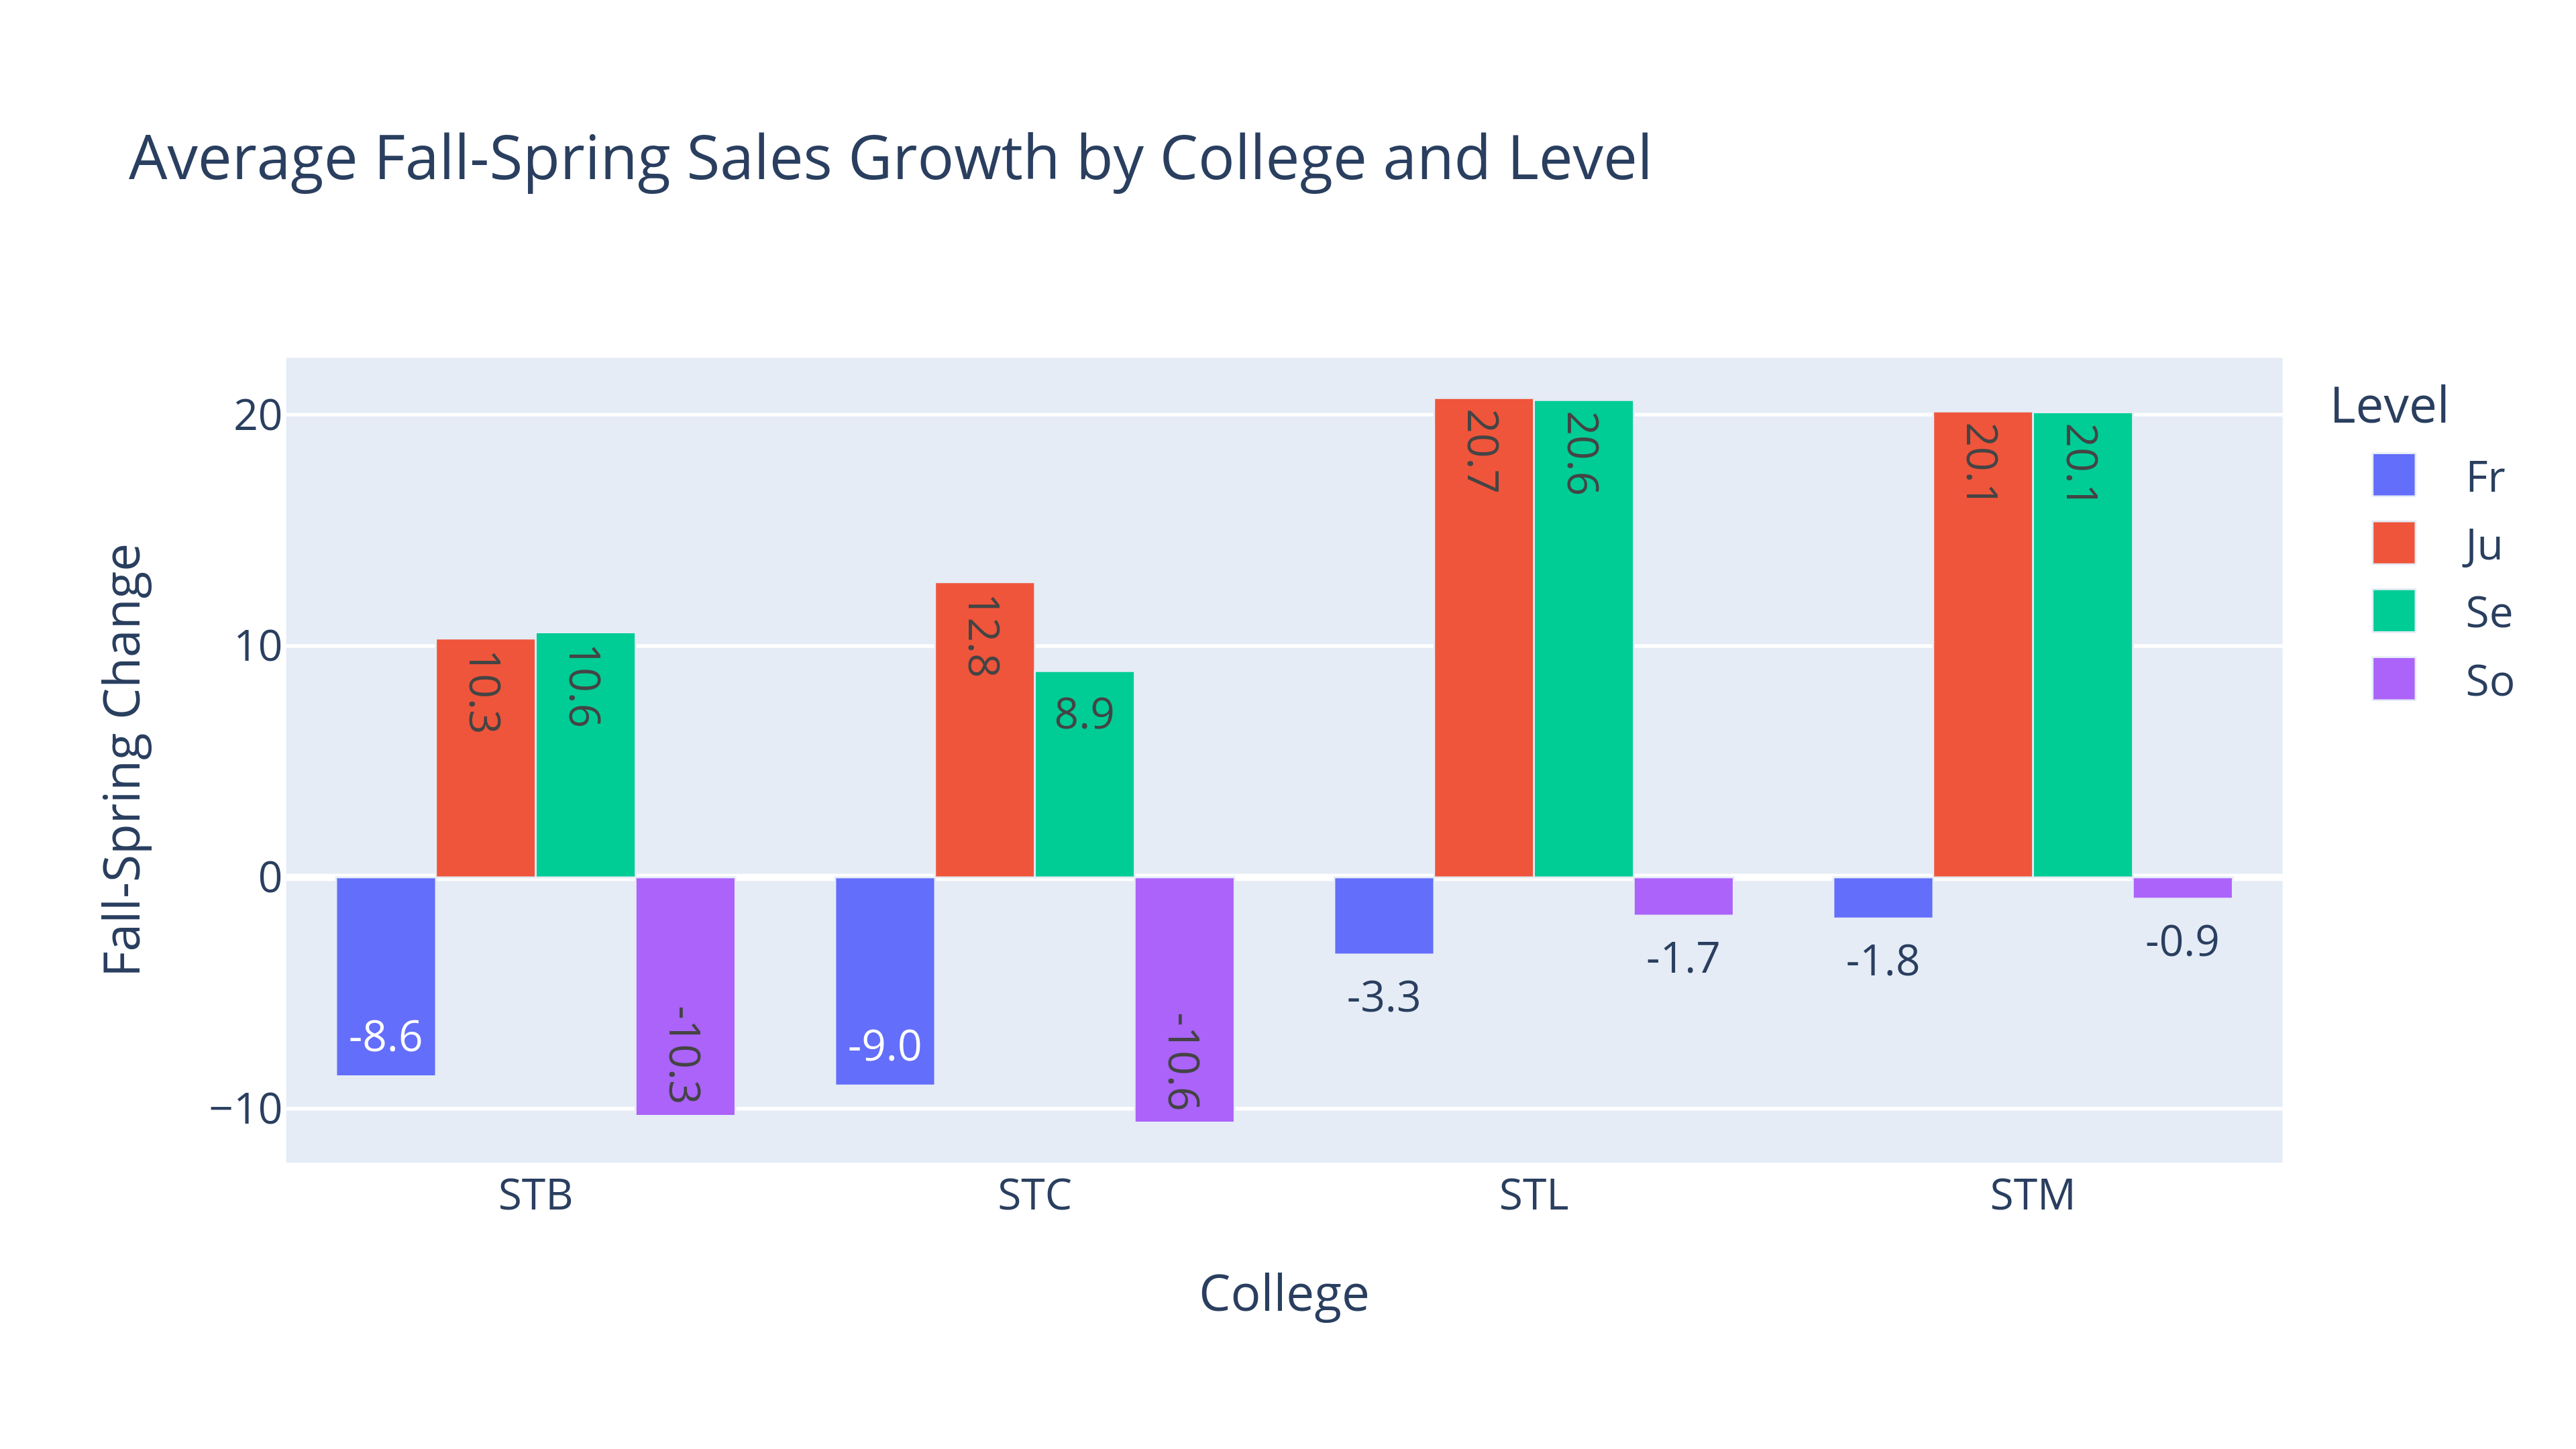

In [91]:
fig_fall_spring_sales_grouped_bar = px.bar(
    df_sales_pivot, x = 'college', y = 'Fall_Spring_Change',
      color = 'level', barmode = 'group', text_auto = '.1f',
      title = 'Average Fall-Spring Sales Growth \
by College and Level').update_layout(
    xaxis_title = 'College', yaxis_title = 'Fall-Spring Change',
legend_title = 'Level')
wadi(fig_fall_spring_sales_grouped_bar, 
     'Charts/fall_spring_sales_grouped_bar', 
     display_type=display_type)

### Creating a linear regression using a formula approach:

(The documentation at https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html proved very helpful in writing this section.)

In [7]:
sales_lr_1 = smf.ols(formula = "Spring ~ Fall + college + level + gender", 
                   data = df_sales) 
sales_lr_results_1 = sales_lr_1.fit()
sales_lr_results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Spring   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     2439.
Date:                Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:30:21   Log-Likelihood:                -76161.
No. Observations:               16384   AIC:                         1.523e+05
Df Residuals:                   16375   BIC:                         1.524e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -10.1260      0.871    -11.624      0.000     -11.833      -8.418
college[T.STC]     0.1049      0.574      0.183      0.855      -1.020       1.230
college[T.STL]     9.1326      0.572     15.977      0.000       8.012      10.253
college[T.STM]     9.0408      0.535     16.893      0.000       7.992      10.090
level[T.Ju]       21.3331      0.598     35.681      0.000      20.161      22.505
level[T.Se]       20.6960      0.564     36.703      0.000      19.591      21.801
level[T.So]       -0.4045      0.609     -0.665      0.506      -1.597       0.788
gender[T.M]       -0.0802      0.395     -0.203      0.839      -0.855       0.694
Fall               1.0020      0.008    126.954      0.000       0.987       1.018
==============================================================================
Omnibus:                        2.301   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.316   Jarque-Bera (JB):                2.306
Skew:                          -0.015   Prob(JB):                        0.316
Kurtosis:                       3.050   Cond. No.                         462.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking the normality of our residuals

For more information on diagnostic tests within Statsmodels, see
https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html
and https://www.statsmodels.org/stable/diagnostic.html .

The model-checking section of Learning Statistics with Python's Linear Regression chapter, available at https://ethanweed.github.io/pythonbook/05.04-regression.html#model-checking, is also a valuable reference. (It does contain some mild language.)

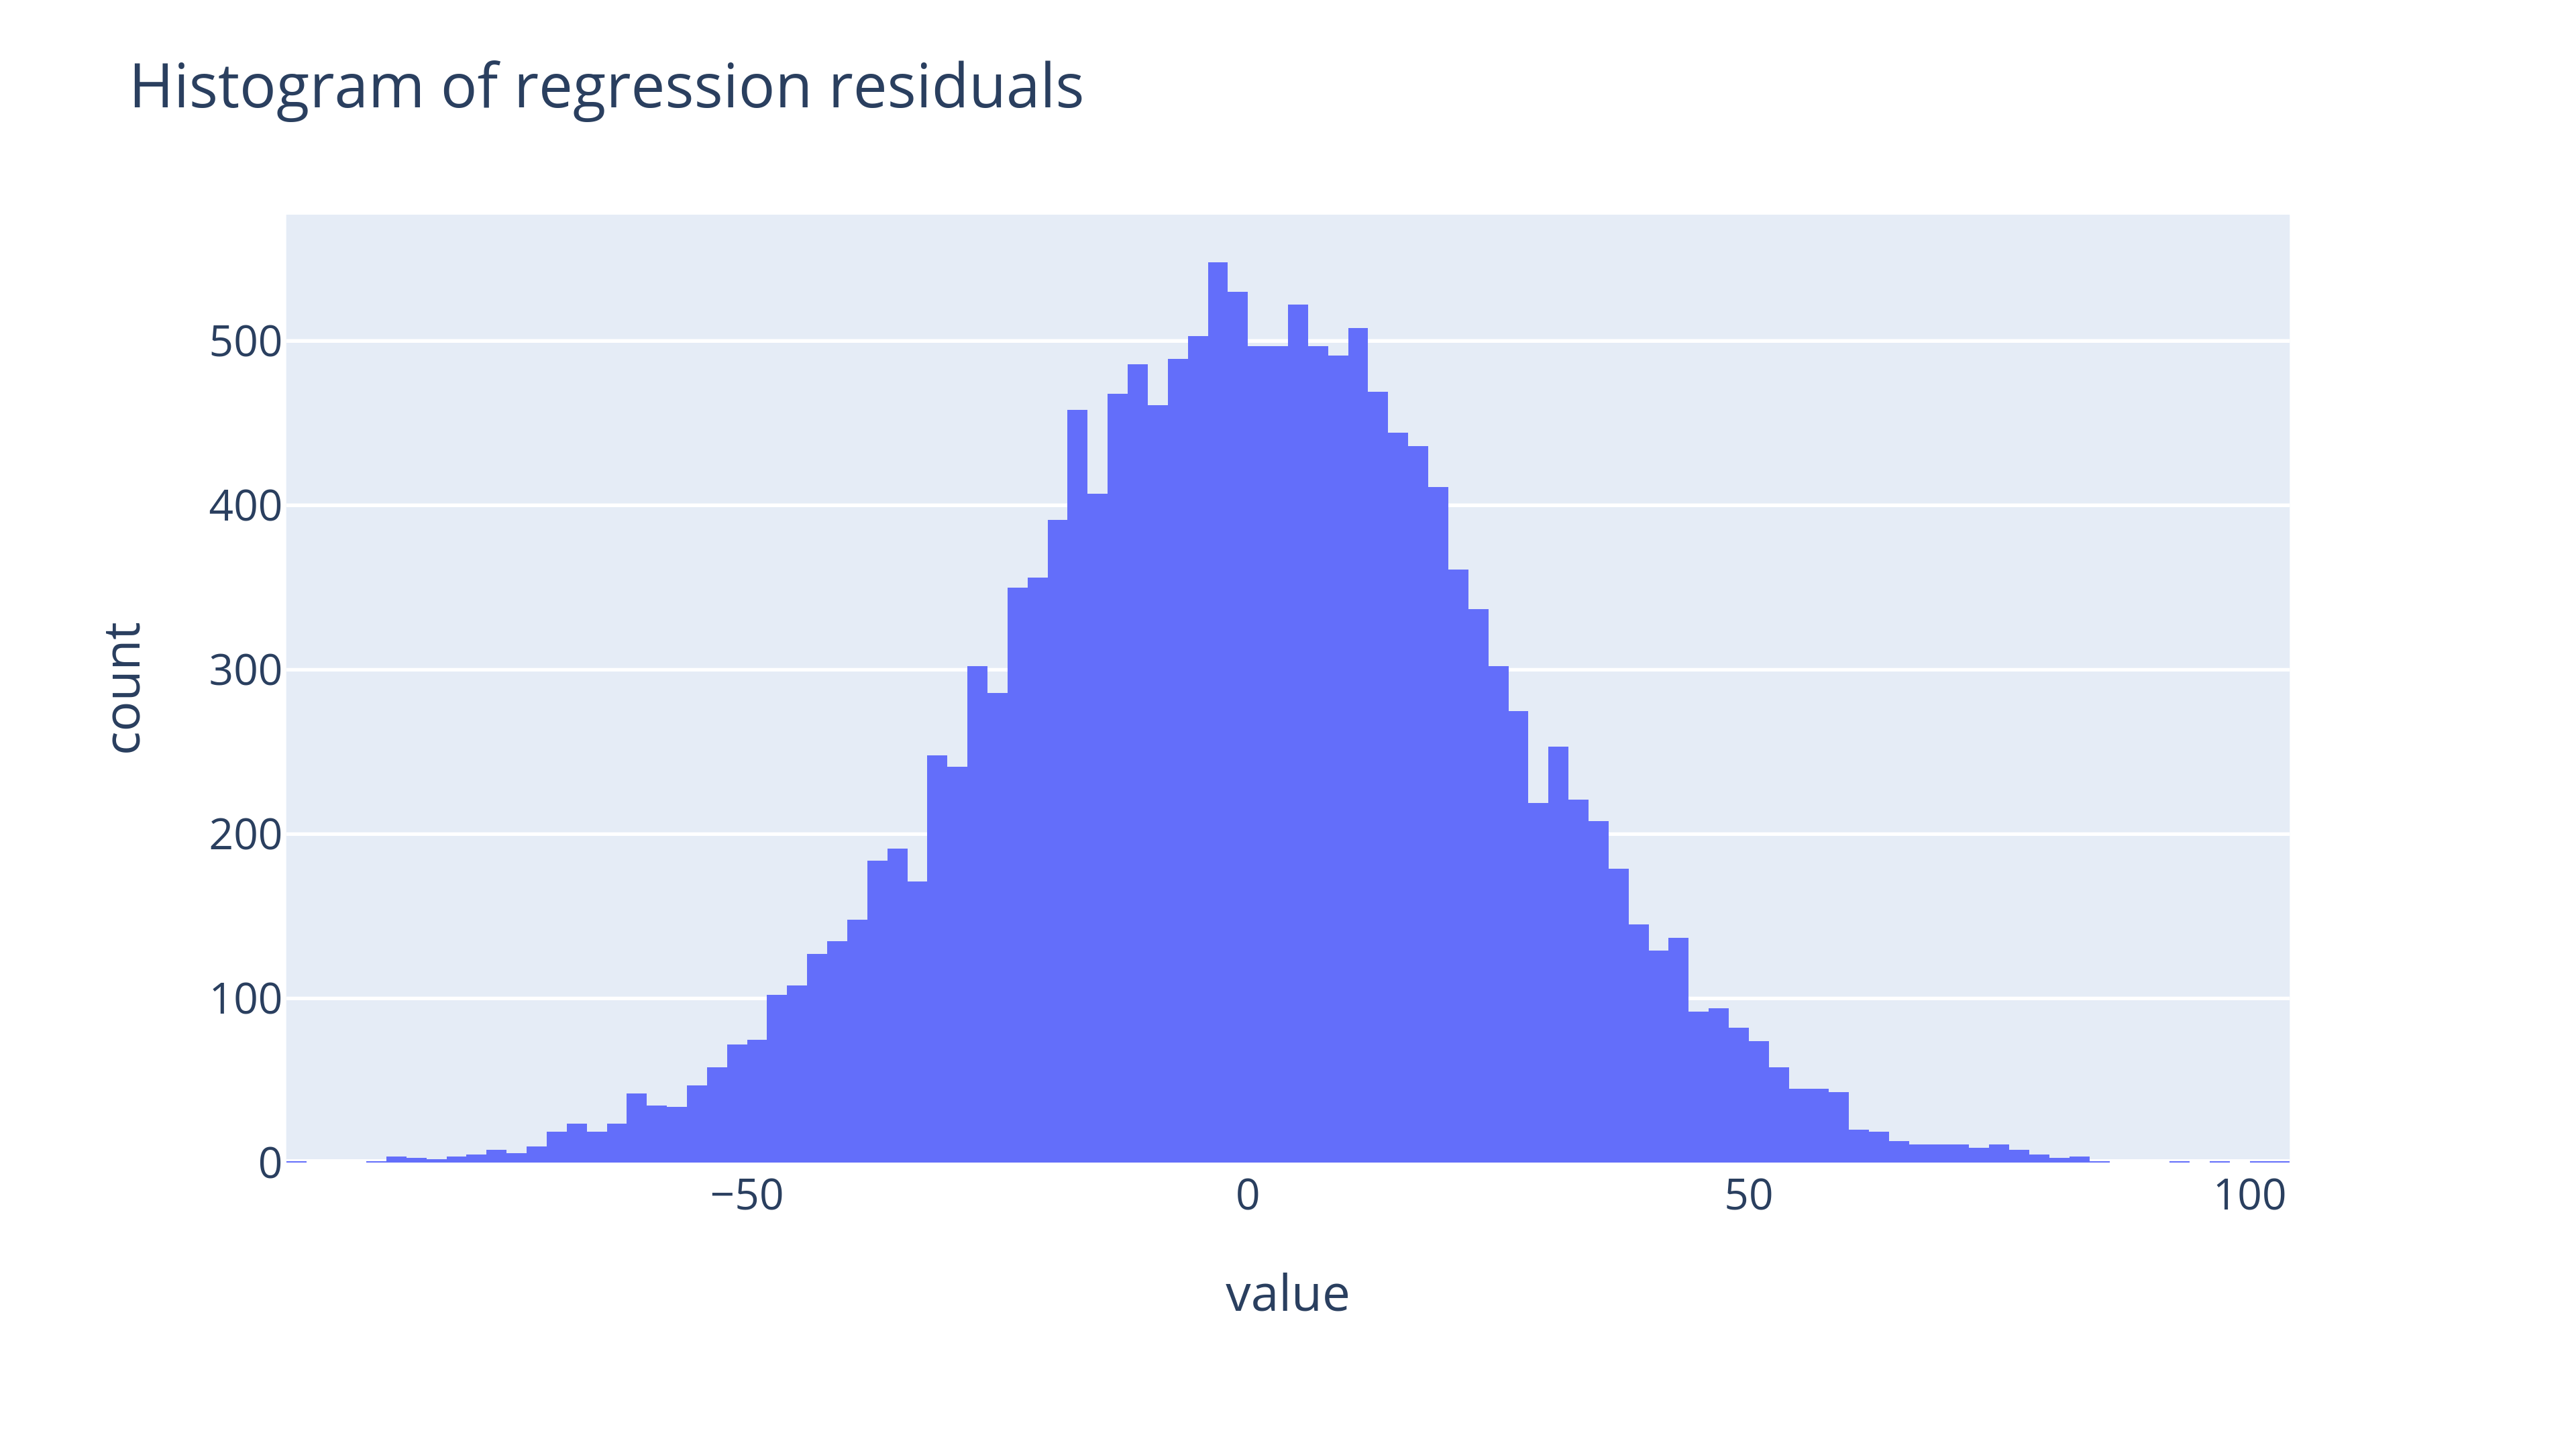

In [100]:
fig_sales_residual_hist = px.histogram(sales_lr_results_1.resid).update_layout(
    showlegend = False, title = 'Histogram of regression residuals')
wadi(fig_sales_residual_hist, 'Charts/sales_residual_hist',
    display_type = display_type)

In [9]:
sms.omni_normtest(sales_lr_results_1.resid)

NormaltestResult(statistic=np.float64(2.3009693235324438), pvalue=np.float64(0.3164833448256659))

## Part 2: Evaluating the relationship between bachelor's degree prevalence and median incomes

## Importing data

In [10]:
df_cmib = pd.read_csv(
    '../Census_Data_Imports/Datasets/education_and_earnings_county.csv')
# 'cmib' is short for 'county median incomes and bachelor's degrees'.
# Simplifying our dataset by removing extraneous fields:

df_cmib.drop(['Year', 'state', 'county'], axis = 1, inplace = True)
# Limiting our output to counties in one of the 50 US states (plus DC):
df_cmib.query("State_Abbrev != 'PR'", inplace = True)
df_cmib

NAME  Total_Population  \
0      Autauga County, Alabama             59285   
1      Baldwin County, Alabama            239945   
2      Barbour County, Alabama             24757   
3         Bibb County, Alabama             22152   
...                        ...               ...   
3140     Teton County, Wyoming             23358   
3141     Uinta County, Wyoming             20605   
3142  Washakie County, Wyoming              7708   
3143    Weston County, Wyoming              6835   

      Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
0                                                 40767                                            
1                                                171988                                            
2                                                 17628                                            
3                                                 15931                                            
...                                                 ...                                            
3140                                              17955                                            
3141                                              13387                                            
3142                                               5501                                            
3143                                               5060                                            

      ...  Pct_With_Bachelors_Degree  State_Abbrev  Region  
0     ...                  28.282680            AL   South  
1     ...                  32.797637            AL   South  
2     ...                  11.464715            AL   South  
3     ...                  11.468207            AL   South  
...   ...                        ...           ...     ...  
3140  ...                  61.219716            WY    West  
3141  ...                  21.319190            WY    West  
3142  ...                  22.032358            WY    West  
3143  ...                  18.043478            WY    West  

[3144 rows x 16 columns]

### Cleaning our dataset

Let's take a look at the average county-level median income values within our dataset:

In [12]:
median_earnings_cols = ['Median_Earnings_for_Total_25plus_Population',
                       'Median_Earnings_Less_Than_HS',
                        'Median_Earnings_HS',
                        'Median_Earnings_Some_College',
                        "Median_Earnings_Bachelors_Degree",
                        "Median_Earnings_Postgraduate"]
df_cmib[median_earnings_cols].mean()

Median_Earnings_for_Total_25plus_Population   -3.794012e+05
Median_Earnings_Less_Than_HS                  -4.089420e+07
Median_Earnings_HS                            -3.779011e+06
Median_Earnings_Some_College                  -1.653628e+06
Median_Earnings_Bachelors_Degree              -4.396728e+06
Median_Earnings_Postgraduate                  -1.795533e+07
dtype: float64

Well, these number don't seem right--they're all negative! What's going on?

The issue here is that the number -666,666,666 is getting used as a code for missing income statistics. The presence of this giant negative number within our dataset is dramatically skewing our average calculations.

You can identify this number by calling .min() on the dataset's median income columns:

In [13]:
df_cmib[median_earnings_cols].min()

Median_Earnings_for_Total_25plus_Population   -666666666
Median_Earnings_Less_Than_HS                  -666666666
Median_Earnings_HS                            -666666666
Median_Earnings_Some_College                  -666666666
Median_Earnings_Bachelors_Degree              -666666666
Median_Earnings_Postgraduate                  -666666666
dtype: int64

I also looked for other unusually small values that might represent additional codes for invalid data, but I didn't find any:

In [14]:
for col in median_earnings_cols:
    print(df_cmib.sort_values(col)[col].unique())

[-666666666      19366      23388 ...      96611      97482     106932]
[-666666666       2499       3417 ...      87929     105764     128554]
[-666666666      13961      15238 ...      75434      84750      88493]
[-666666666      16806      17040 ...      90183      93458     100365]
[-666666666       2499      18963 ...     110960     115313     158333]
[-666666666       2499      13750 ...     154872     164519     250001]


I'll now remove invalid 'Median_Earnings_for_Total_25+_Population' entries from our dataset by filtering out rows with *negative* values. (I could have only filtered out rows with entries of -666666666, but that code would fail to work going forward if the Census Bureau happened to replace that number with a different one.)

Since the only earnings row that we'll be using in our dataset is the 'Median_Earnings_for_Total_25+_Population' one, I won't filter out invalid numbers in other columns just yet, as that would cause many rows with valid 'Median_Earnings_for_Total_25+_Population' entries to get removed.

In [93]:
df_cmib.query("`Median_Earnings_for_Total_25plus_Population` >= 0", 
              inplace = True)
# Enclosing this field in backticks helped query() correctly parse it.
df_cmib.head()

NAME  Total_Population  \
0  Autauga County, Alabama             59285   
1  Baldwin County, Alabama            239945   
2  Barbour County, Alabama             24757   
3     Bibb County, Alabama             22152   
4   Blount County, Alabama             59292   

   Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
0                                              40767                                            
1                                             171988                                            
2                                              17628                                            
3                                              15931                                            
4                                              40991                                            

   ...  State_Abbrev  Region  Pct_With_Bachelors_Degree_Squared  
0  ...            AL   South                         799.909966  
1  ...            AL   South                        1075.684996  
2  ...            AL   South                         131.439695  
3  ...            AL   South                         131.519764  
4  ...            AL   South                         242.706162  

[5 rows x 17 columns]

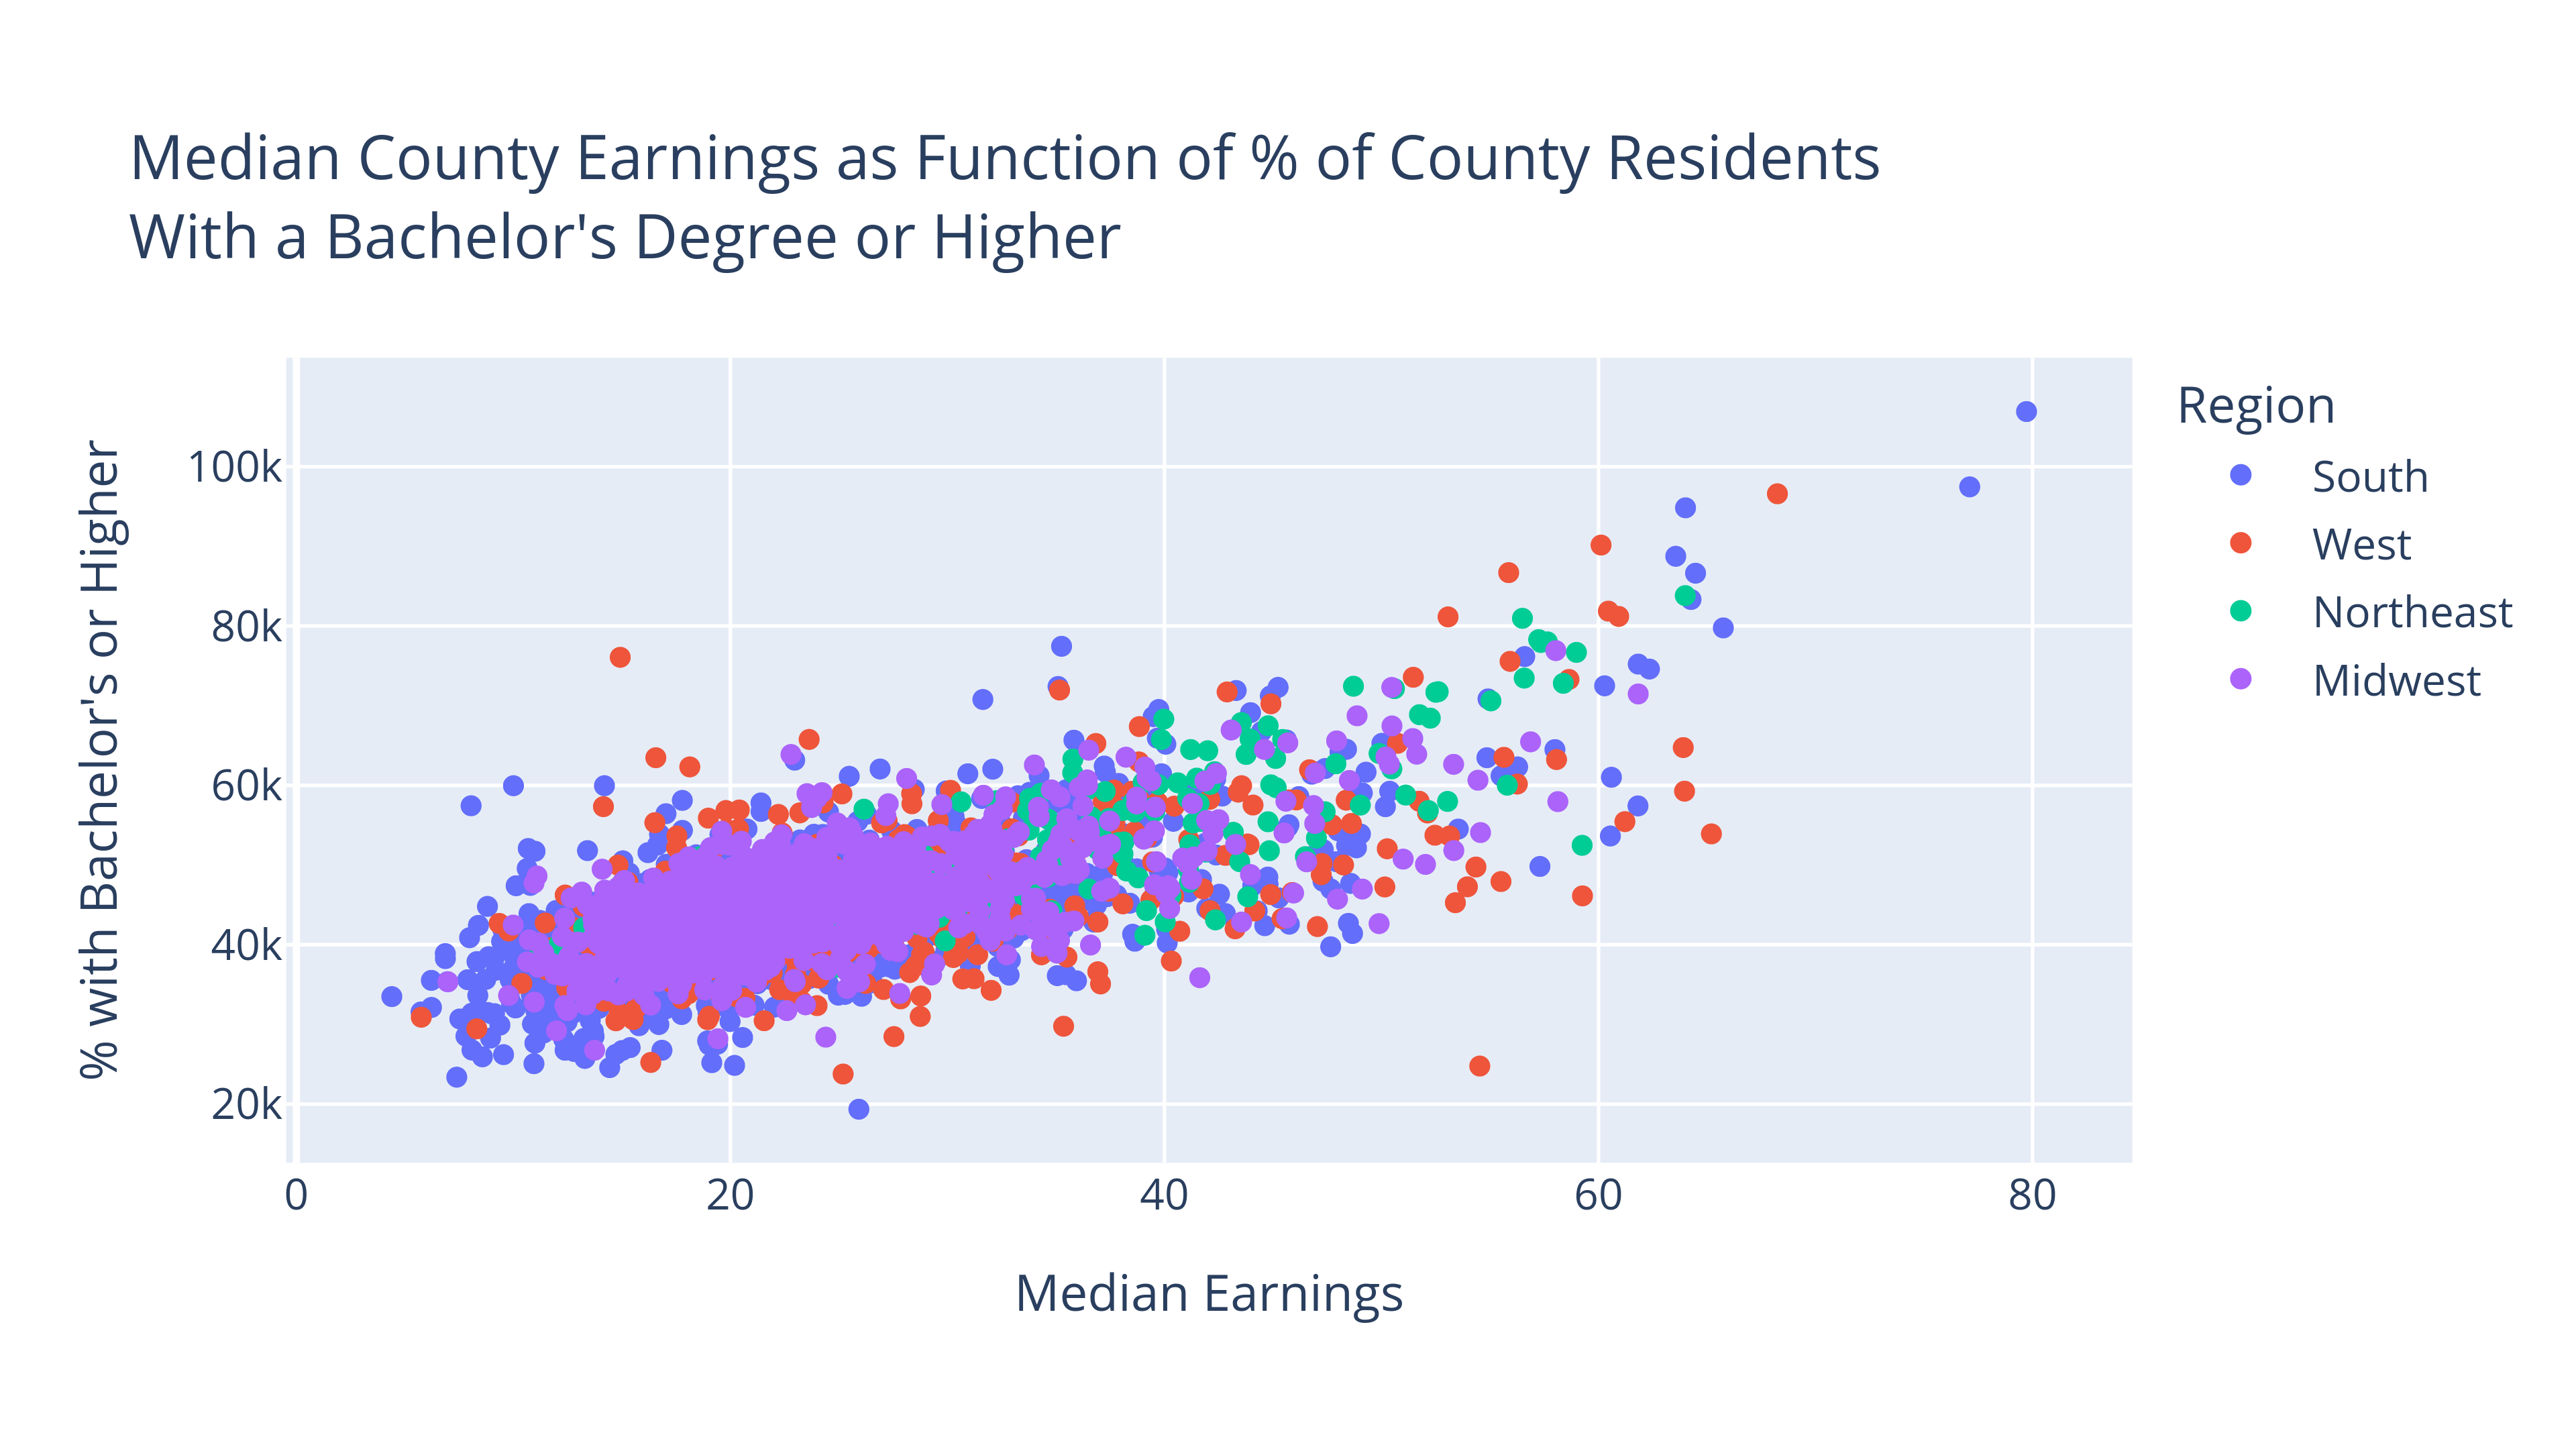

In [110]:
fig_ba_pct_earnings_scatter = px.scatter(
    df_cmib, x = "Pct_With_Bachelors_Degree", 
           y = 'Median_Earnings_for_Total_25plus_Population',
           color = 'Region', hover_data = 'NAME',
title = "Median County Earnings as Function of % of County \
Residents<br>With a Bachelor's Degree or Higher").update_layout(
    xaxis_title = 'Median Earnings', yaxis_title = "% with Bachelor's \
or Higher")
wadi(fig_ba_pct_earnings_scatter, 'Charts/county_ba_pct_earnings_scatter',
     display_type = display_type)

I'm seeing a hint of a curve in the above scatter plot. Therefore, in order to allow our model to better account for this curve, I'll add in a squared version of the 'Pct_With_Bachelors_Degree' column. 

In [18]:
df_cmib['Pct_With_Bachelors_Degree_Squared'] = df_cmib[
'Pct_With_Bachelors_Degree']**2

In [19]:
cmib_lr_1 = smf.ols(formula = "Median_Earnings_for_Total_\
25plus_Population ~ Pct_With_Bachelors_Degree + \
Pct_With_Bachelors_Degree_Squared", 
                   data = df_cmib) 
cmib_lr_results_1 = cmib_lr_1.fit()
cmib_lr_results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median_Earnings_for_Total_25plus_Population   R-squared:                       0.498
Model:                                                     OLS   Adj. R-squared:                  0.497
Method:                                          Least Squares   F-statistic:                     1555.
Date:                                         Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                                                 21:30:21   Log-Likelihood:                -31696.
No. Observations:                                         3142   AIC:                         6.340e+04
Df Residuals:                                             3139   BIC:                         6.342e+04
Df Model:                                                    2                                         
Covariance Type:                                     nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          3.477e+04    588.871     59.038      0.000    3.36e+04    3.59e+04
Pct_With_Bachelors_Degree           283.5300     41.660      6.806      0.000     201.847     365.213
Pct_With_Bachelors_Degree_Squared     4.5607      0.655      6.961      0.000       3.276       5.845
==============================================================================
Omnibus:                      175.709   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              664.486
Skew:                           0.119   Prob(JB):                    5.11e-145
Kurtosis:                       5.240   Cond. No.                     5.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All three of our predictors (including the intercept) are significantly significant, so it makes sense to keep each one within our model.

Next, let's create a revised version of this regression model that also takes individuals' regions into account.

In [20]:
cmib_lr_2 = smf.ols(formula = "Median_Earnings_for_Total_\
25plus_Population ~ Pct_With_Bachelors_Degree + \
Pct_With_Bachelors_Degree_Squared + Region", 
                   data = df_cmib) 
cmib_lr_results_2 = cmib_lr_2.fit()
cmib_lr_results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median_Earnings_for_Total_25plus_Population   R-squared:                       0.514
Model:                                                     OLS   Adj. R-squared:                  0.513
Method:                                          Least Squares   F-statistic:                     663.0
Date:                                         Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                                                 21:30:21   Log-Likelihood:                -31645.
No. Observations:                                         3142   AIC:                         6.330e+04
Df Residuals:                                             3136   BIC:                         6.334e+04
Df Model:                                                    5                                         
Covariance Type:                                     nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          3.709e+04    635.611     58.356      0.000    3.58e+04    3.83e+04
Region[T.Northeast]                1232.3922    436.812      2.821      0.005     375.926    2088.858
Region[T.South]                   -1944.9595    237.961     -8.173      0.000   -2411.535   -1478.384
Region[T.West]                    -1682.2203    326.246     -5.156      0.000   -2321.897   -1042.543
Pct_With_Bachelors_Degree           199.2065     42.178      4.723      0.000     116.507     281.906
Pct_With_Bachelors_Degree_Squared     5.6411      0.657      8.584      0.000       4.353       6.930
==============================================================================
Omnibus:                      225.565   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              902.064
Skew:                           0.245   Prob(JB):                    1.32e-196
Kurtosis:                       5.579   Cond. No.                     5.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Each region-level predictor is significant as well.

In [21]:
df_cmib_pred_vs_actual = df_cmib.copy()[
['NAME', 'Median_Earnings_for_Total_25plus_Population',
 'Pct_With_Bachelors_Degree', 'Pct_With_Bachelors_Degree_Squared', 
 'Region']]
df_cmib_pred_vs_actual['Pred_Val'] = cmib_lr_results_2.predict(
    df_cmib_pred_vs_actual[
    ['Pct_With_Bachelors_Degree',
     'Pct_With_Bachelors_Degree_Squared', 'Region']])
df_cmib_pred_vs_actual
df_cmib_pred_vs_actual['Actual-Pred'] = (
    df_cmib_pred_vs_actual[
    'Median_Earnings_for_Total_25plus_Population'] - 
    df_cmib_pred_vs_actual['Pred_Val'])
df_cmib_pred_vs_actual.sort_values('Actual-Pred')

NAME  \
285      Mineral County, Colorado   
2593        Edwards County, Texas   
271     Gunnison County, Colorado   
571          Custer County, Idaho   
...                           ...   
1202     Charles County, Maryland   
2874     Loudoun County, Virginia   
1198     Calvert County, Maryland   
87    North Slope Borough, Alaska   

      Median_Earnings_for_Total_25plus_Population  Pct_With_Bachelors_Degree  \
285                                         24783                  54.532164   
2593                                        19366                  25.921909   
271                                         46144                  59.265428   
571                                         23782                  25.196424   
...                                           ...                        ...   
1202                                        70792                  31.637943   
2874                                        94853                  64.013746   
1198                                        77471                  35.262776   
87                                          76090                  14.927417   

      Pct_With_Bachelors_Degree_Squared Region      Pred_Val   Actual-Pred  
285                         2973.756882   West  63048.278889 -38265.278889  
2593                         671.945361  South  44101.347702 -24735.347702  
271                         3512.390929   West  67029.686479 -20885.686479  
571                          634.859769   West  44010.360520 -20228.360520  
...                                 ...    ...           ...           ...  
1202                        1000.959444  South  47096.033650  23695.966350  
2874                        4097.759728  South  71014.991163  23838.008837  
1198                        1243.463362  South  49186.122657  28284.877343  
87                           222.827783   West  39640.377288  36449.622712  

[3142 rows x 7 columns]

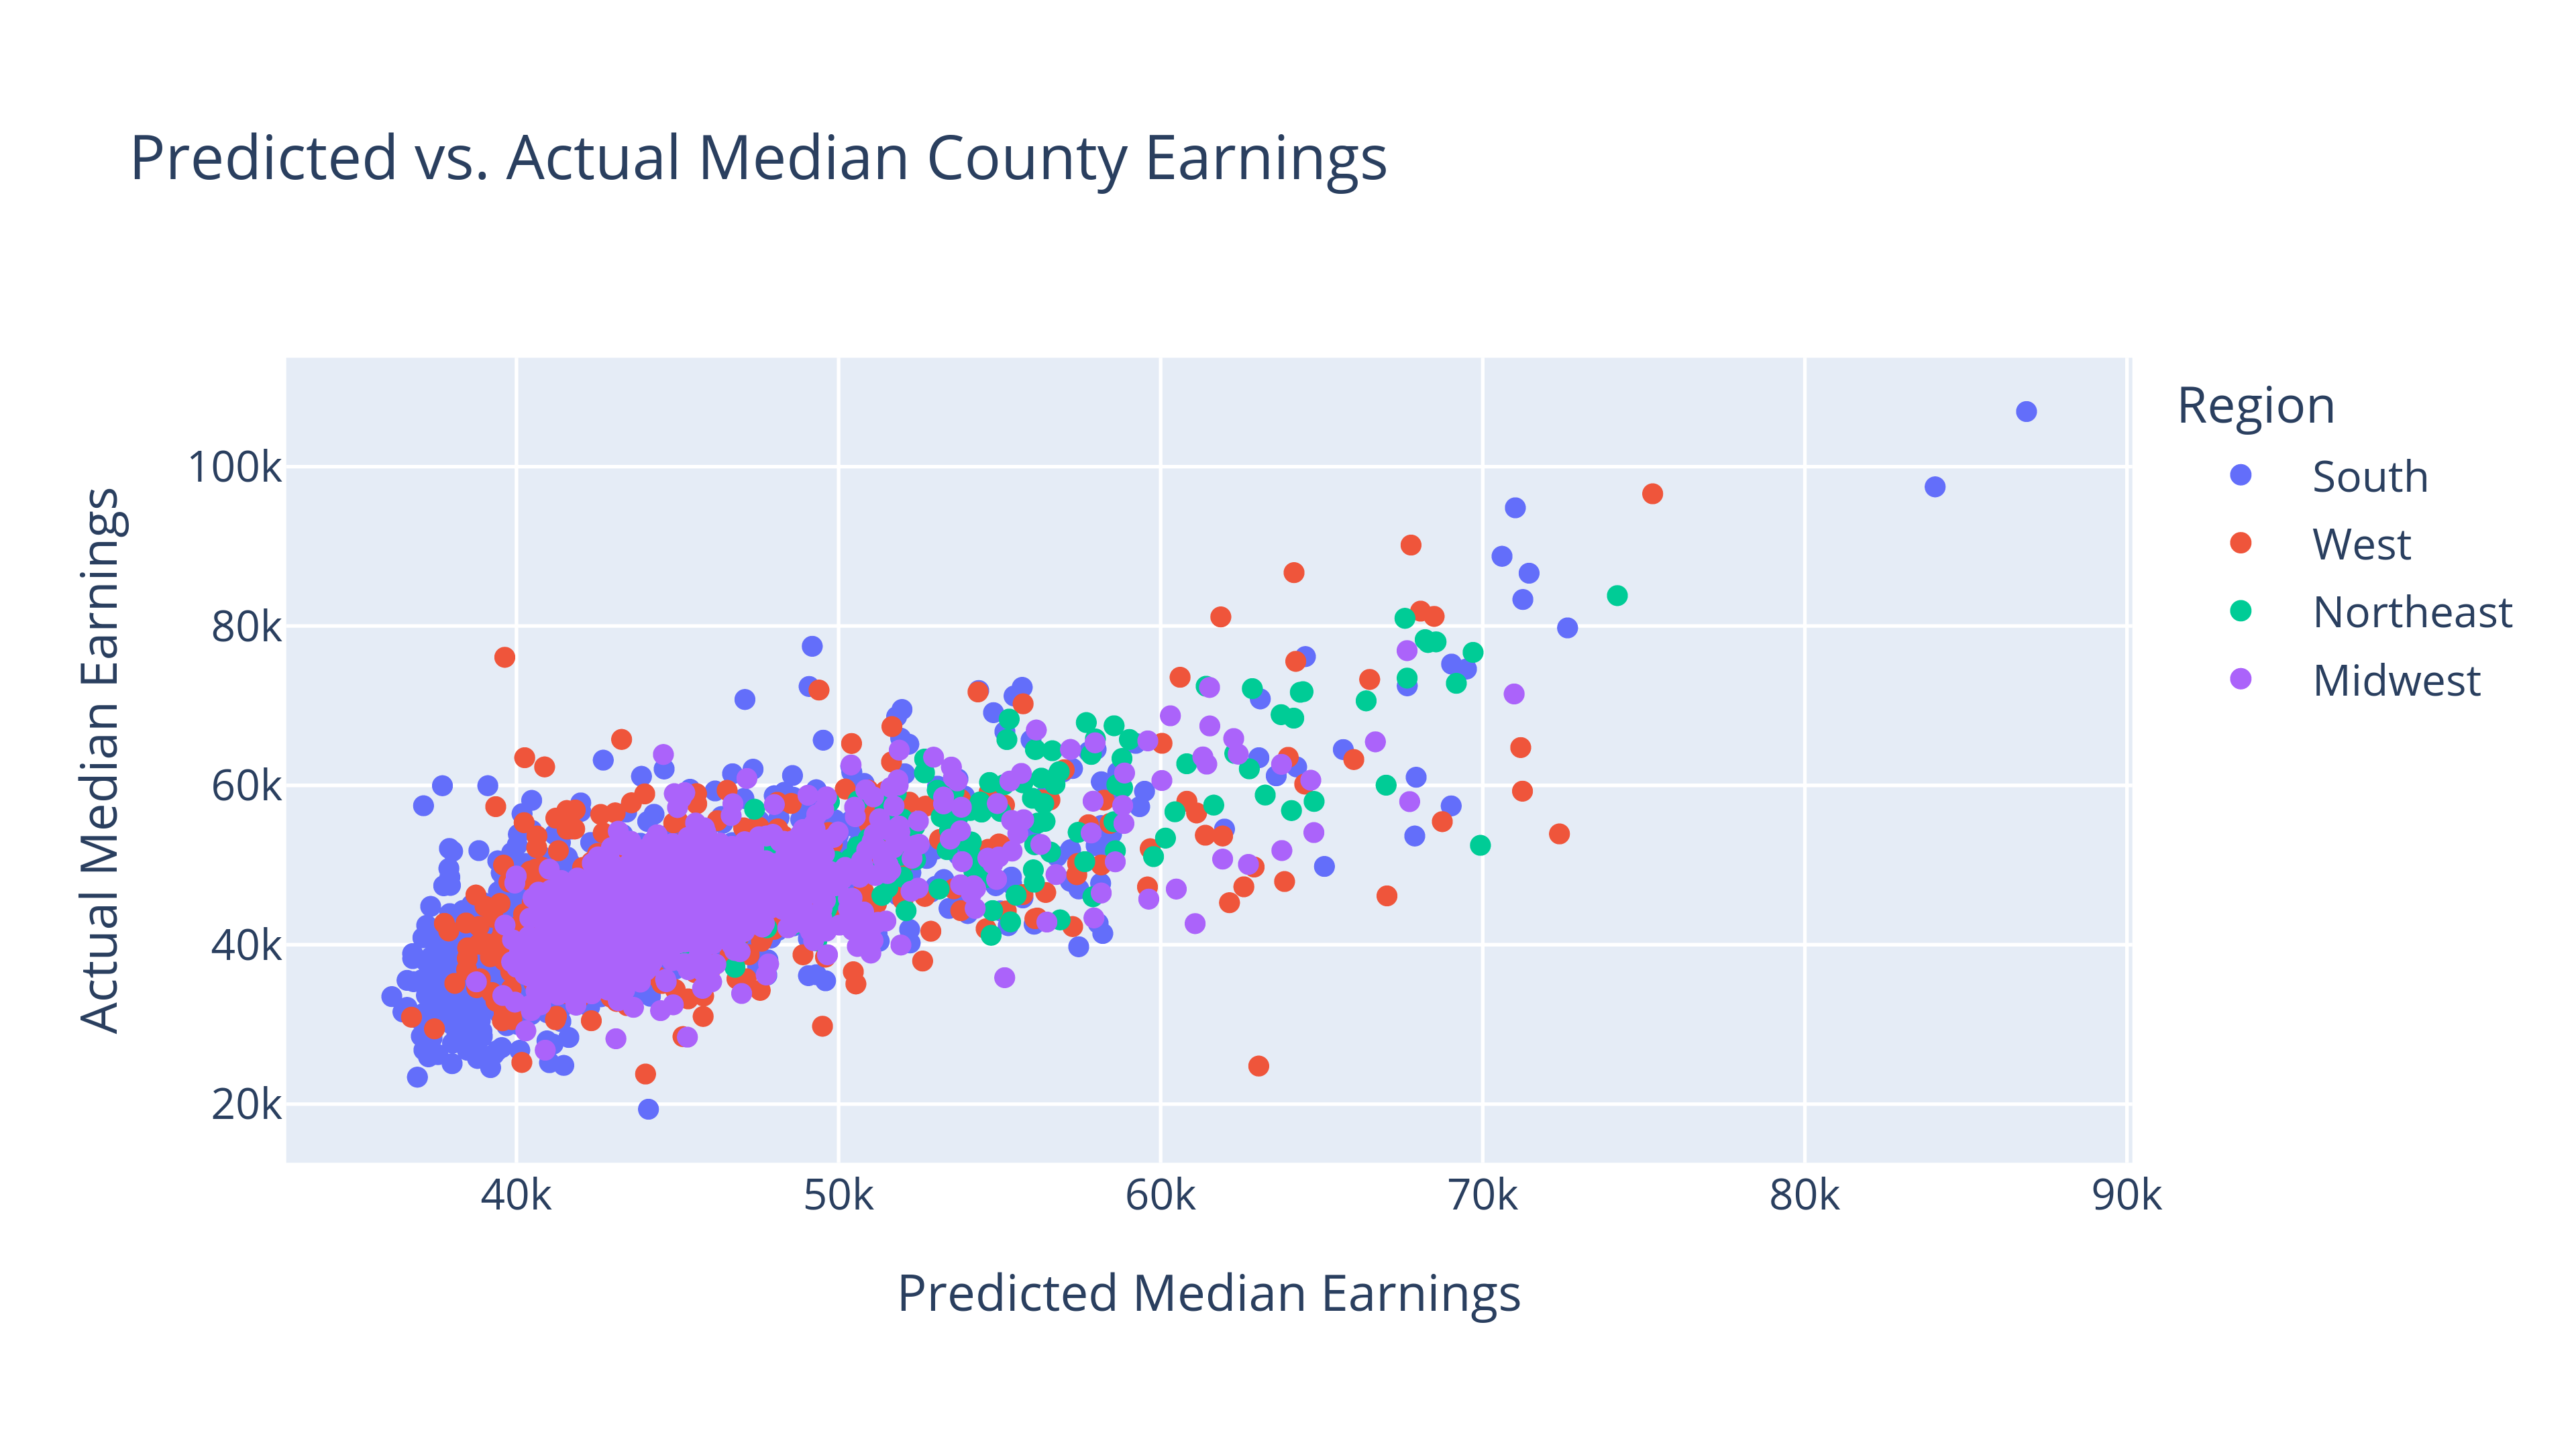

In [129]:
fig_cmib_pred_vs_actual = px.scatter(
    df_cmib_pred_vs_actual, x = 'Pred_Val', 
           y = 'Median_Earnings_for_Total_25plus_Population', 
           color = 'Region',
          hover_data = 'NAME', title = "Predicted vs. Actual Median \
County Earnings").update_layout(
    xaxis_title = 'Predicted Median Earnings', 
    yaxis_title = 'Actual Median Earnings')
wadi(fig_cmib_pred_vs_actual, 'Charts/cmib_pred_vs_actual',
     display_type=display_type)

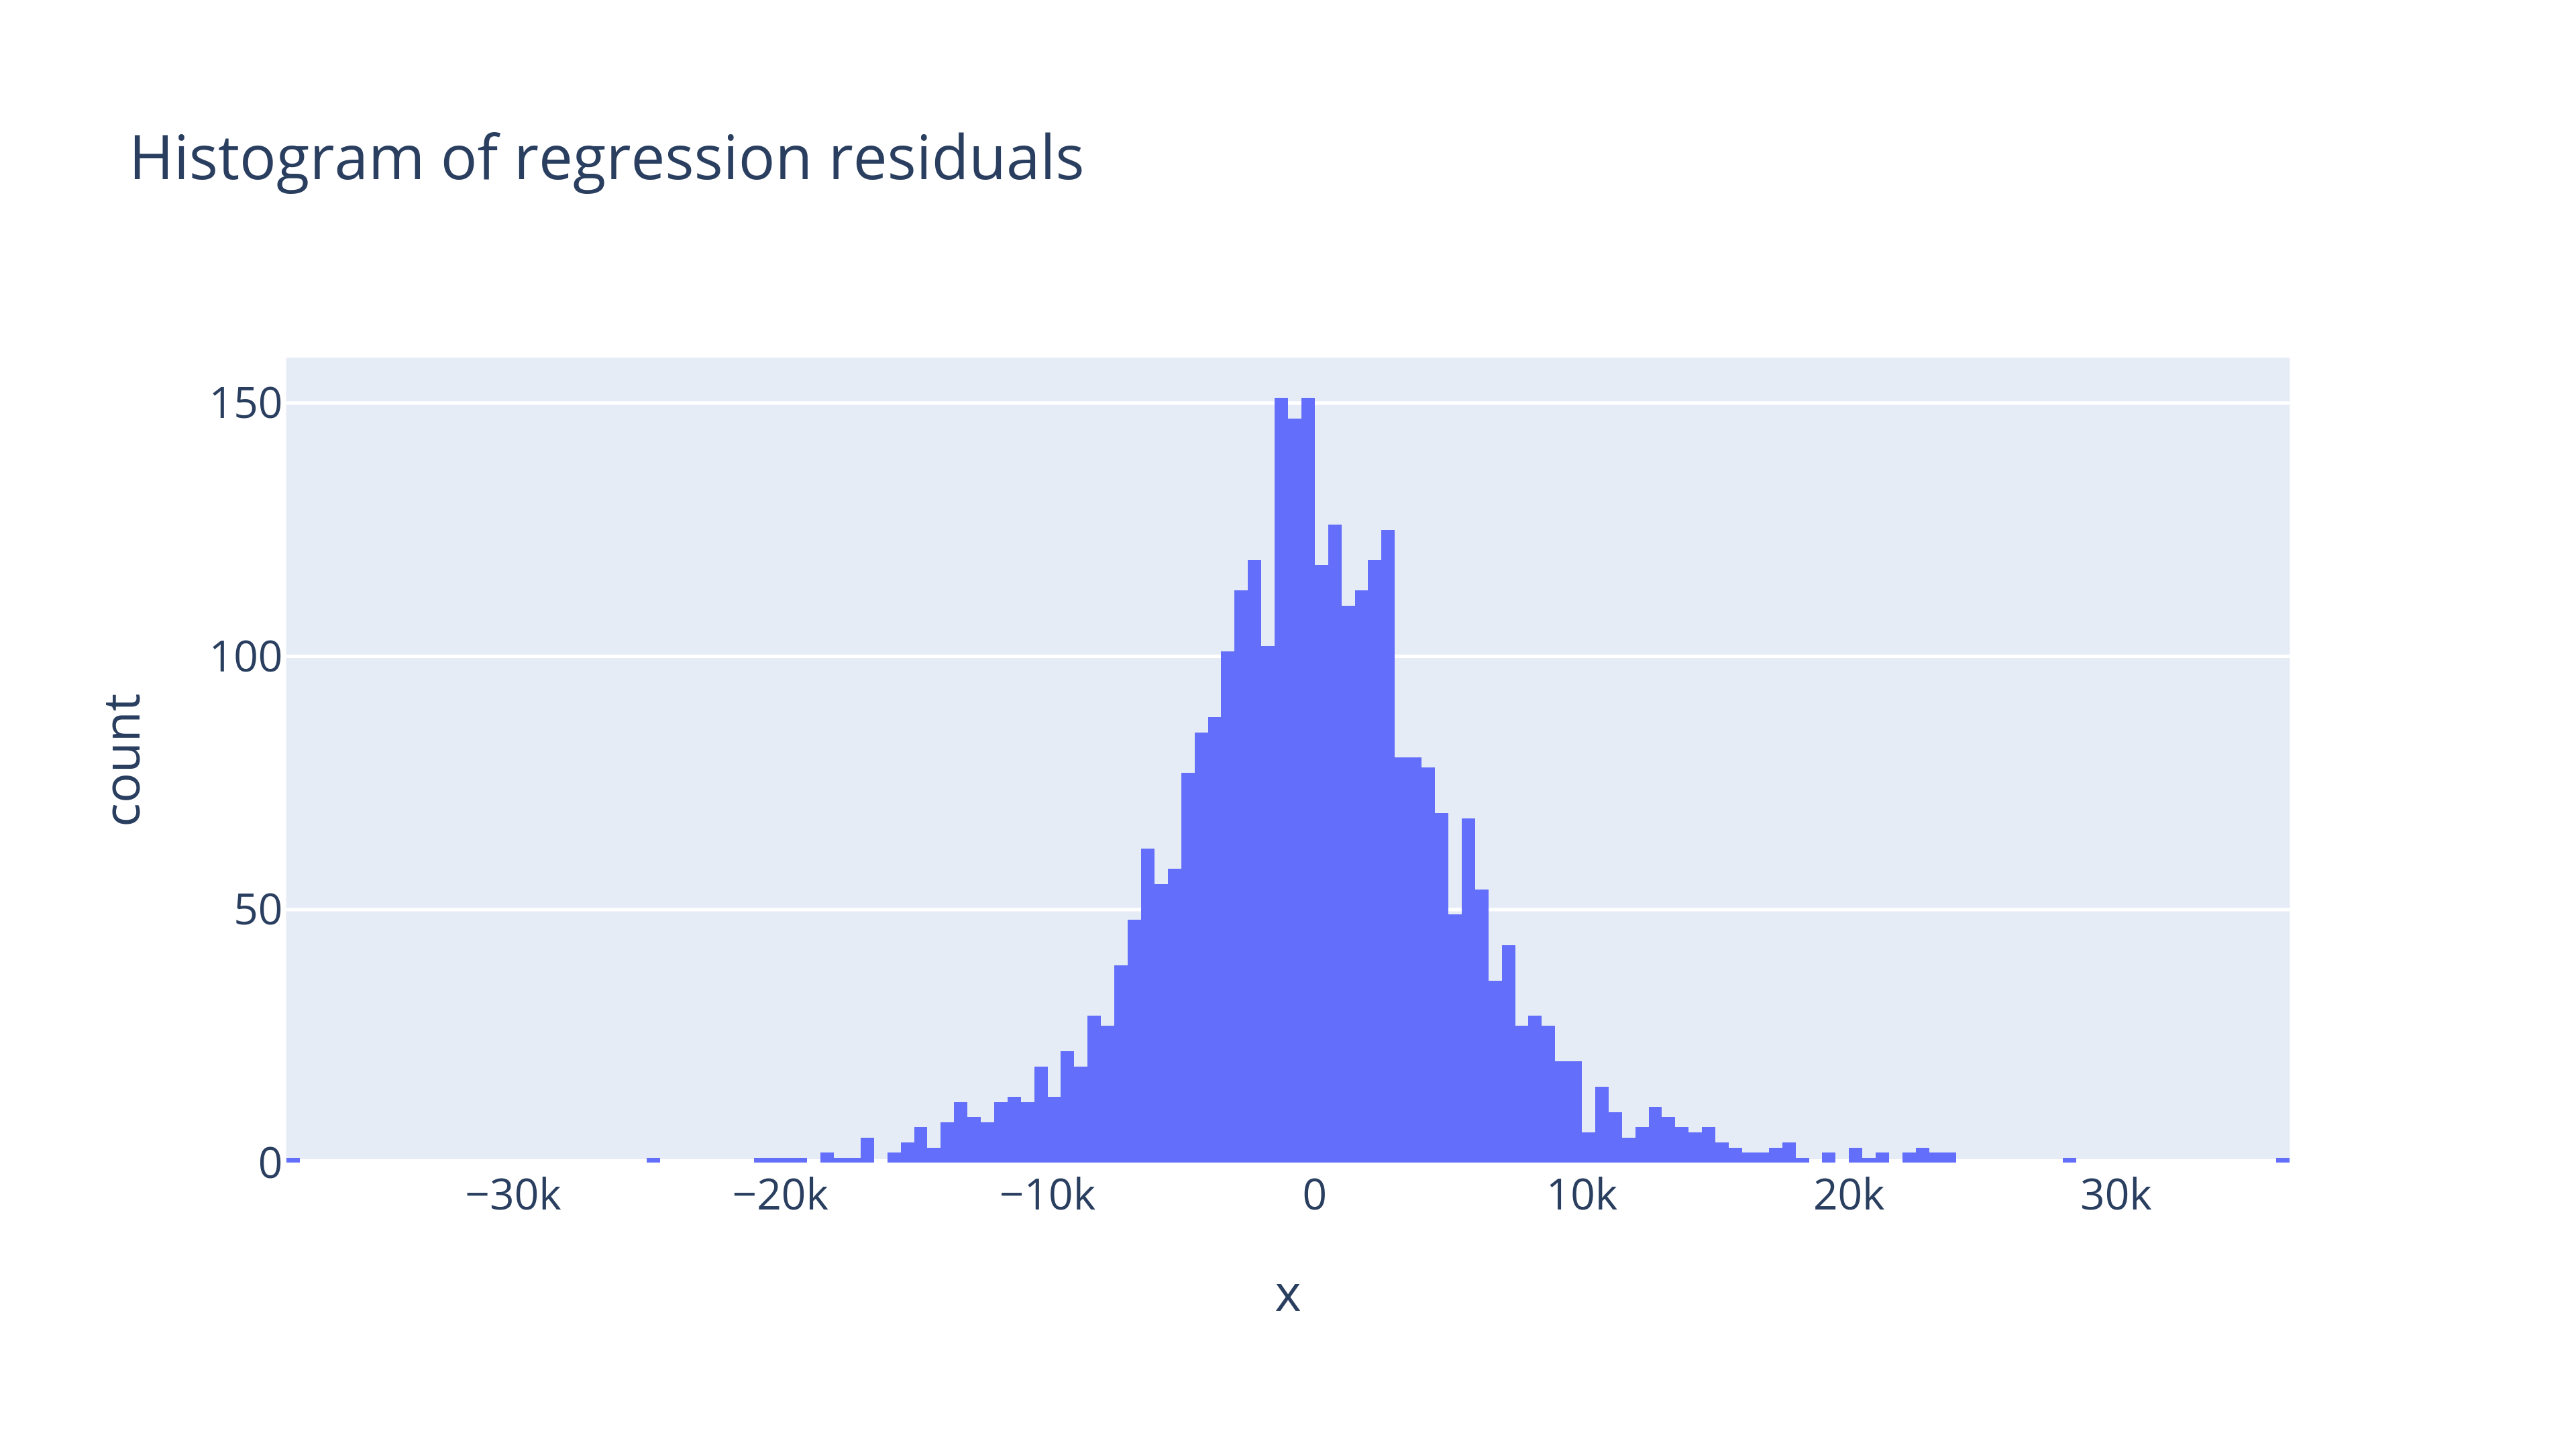

In [104]:
fig_cmib_hist = px.histogram(
    x = cmib_lr_results_2.resid, 
    title = 'Histogram of regression residuals')
wadi(fig_cmib_hist, 'Charts/cmib_residual',
     display_type=display_type)


In [105]:
sms.omni_normtest(cmib_lr_results_2.resid)

NormaltestResult(statistic=np.float64(225.5648729751166), pvalue=np.float64(1.0452259364221645e-49))

## Performing state-level regressions:

In [106]:
df_smib = pd.read_csv(
    '../Census_Data_Imports/Datasets/education_and_earnings_state.csv')
df_smib.query("State_Abbrev not in ['PR']", inplace = True)
df_smib.drop(['Year', 'state', 'State_Abbrev'], axis = 1, inplace = True)
# Limiting our output to counties in one of the 50 US states (plus DC):

df_smib.head()

NAME  Total_Population  \
0     Alabama           5054253   
1      Alaska            733971   
2     Arizona           7268175   
3    Arkansas           3032651   
4  California          39242785   

   Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
0                                            3448302                                            
1                                             487903                                            
2                                            4990633                                            
3                                            2043779                                            
4                                           26941198                                            

   ...  Median_Earnings_Postgraduate  Pct_With_Bachelors_Degree  Region  
0  ...                         72667                  27.755139   South  
1  ...                         90606                  31.242276    West  
2  ...                         82033                  32.610332    West  
3  ...                         72437                  25.111375   South  
4  ...                        108925                  36.503058    West  

[5 rows x 15 columns]

Confirming that no median earnings columns within our state-level dataset contain the invalid entries that we saw in our county-level file:

In [26]:
df_smib[median_earnings_cols].min()

Median_Earnings_for_Total_25plus_Population    41331
Median_Earnings_Less_Than_HS                   26749
Median_Earnings_HS                             33805
Median_Earnings_Some_College                   38500
Median_Earnings_Bachelors_Degree               52657
Median_Earnings_Postgraduate                   64563
dtype: int64

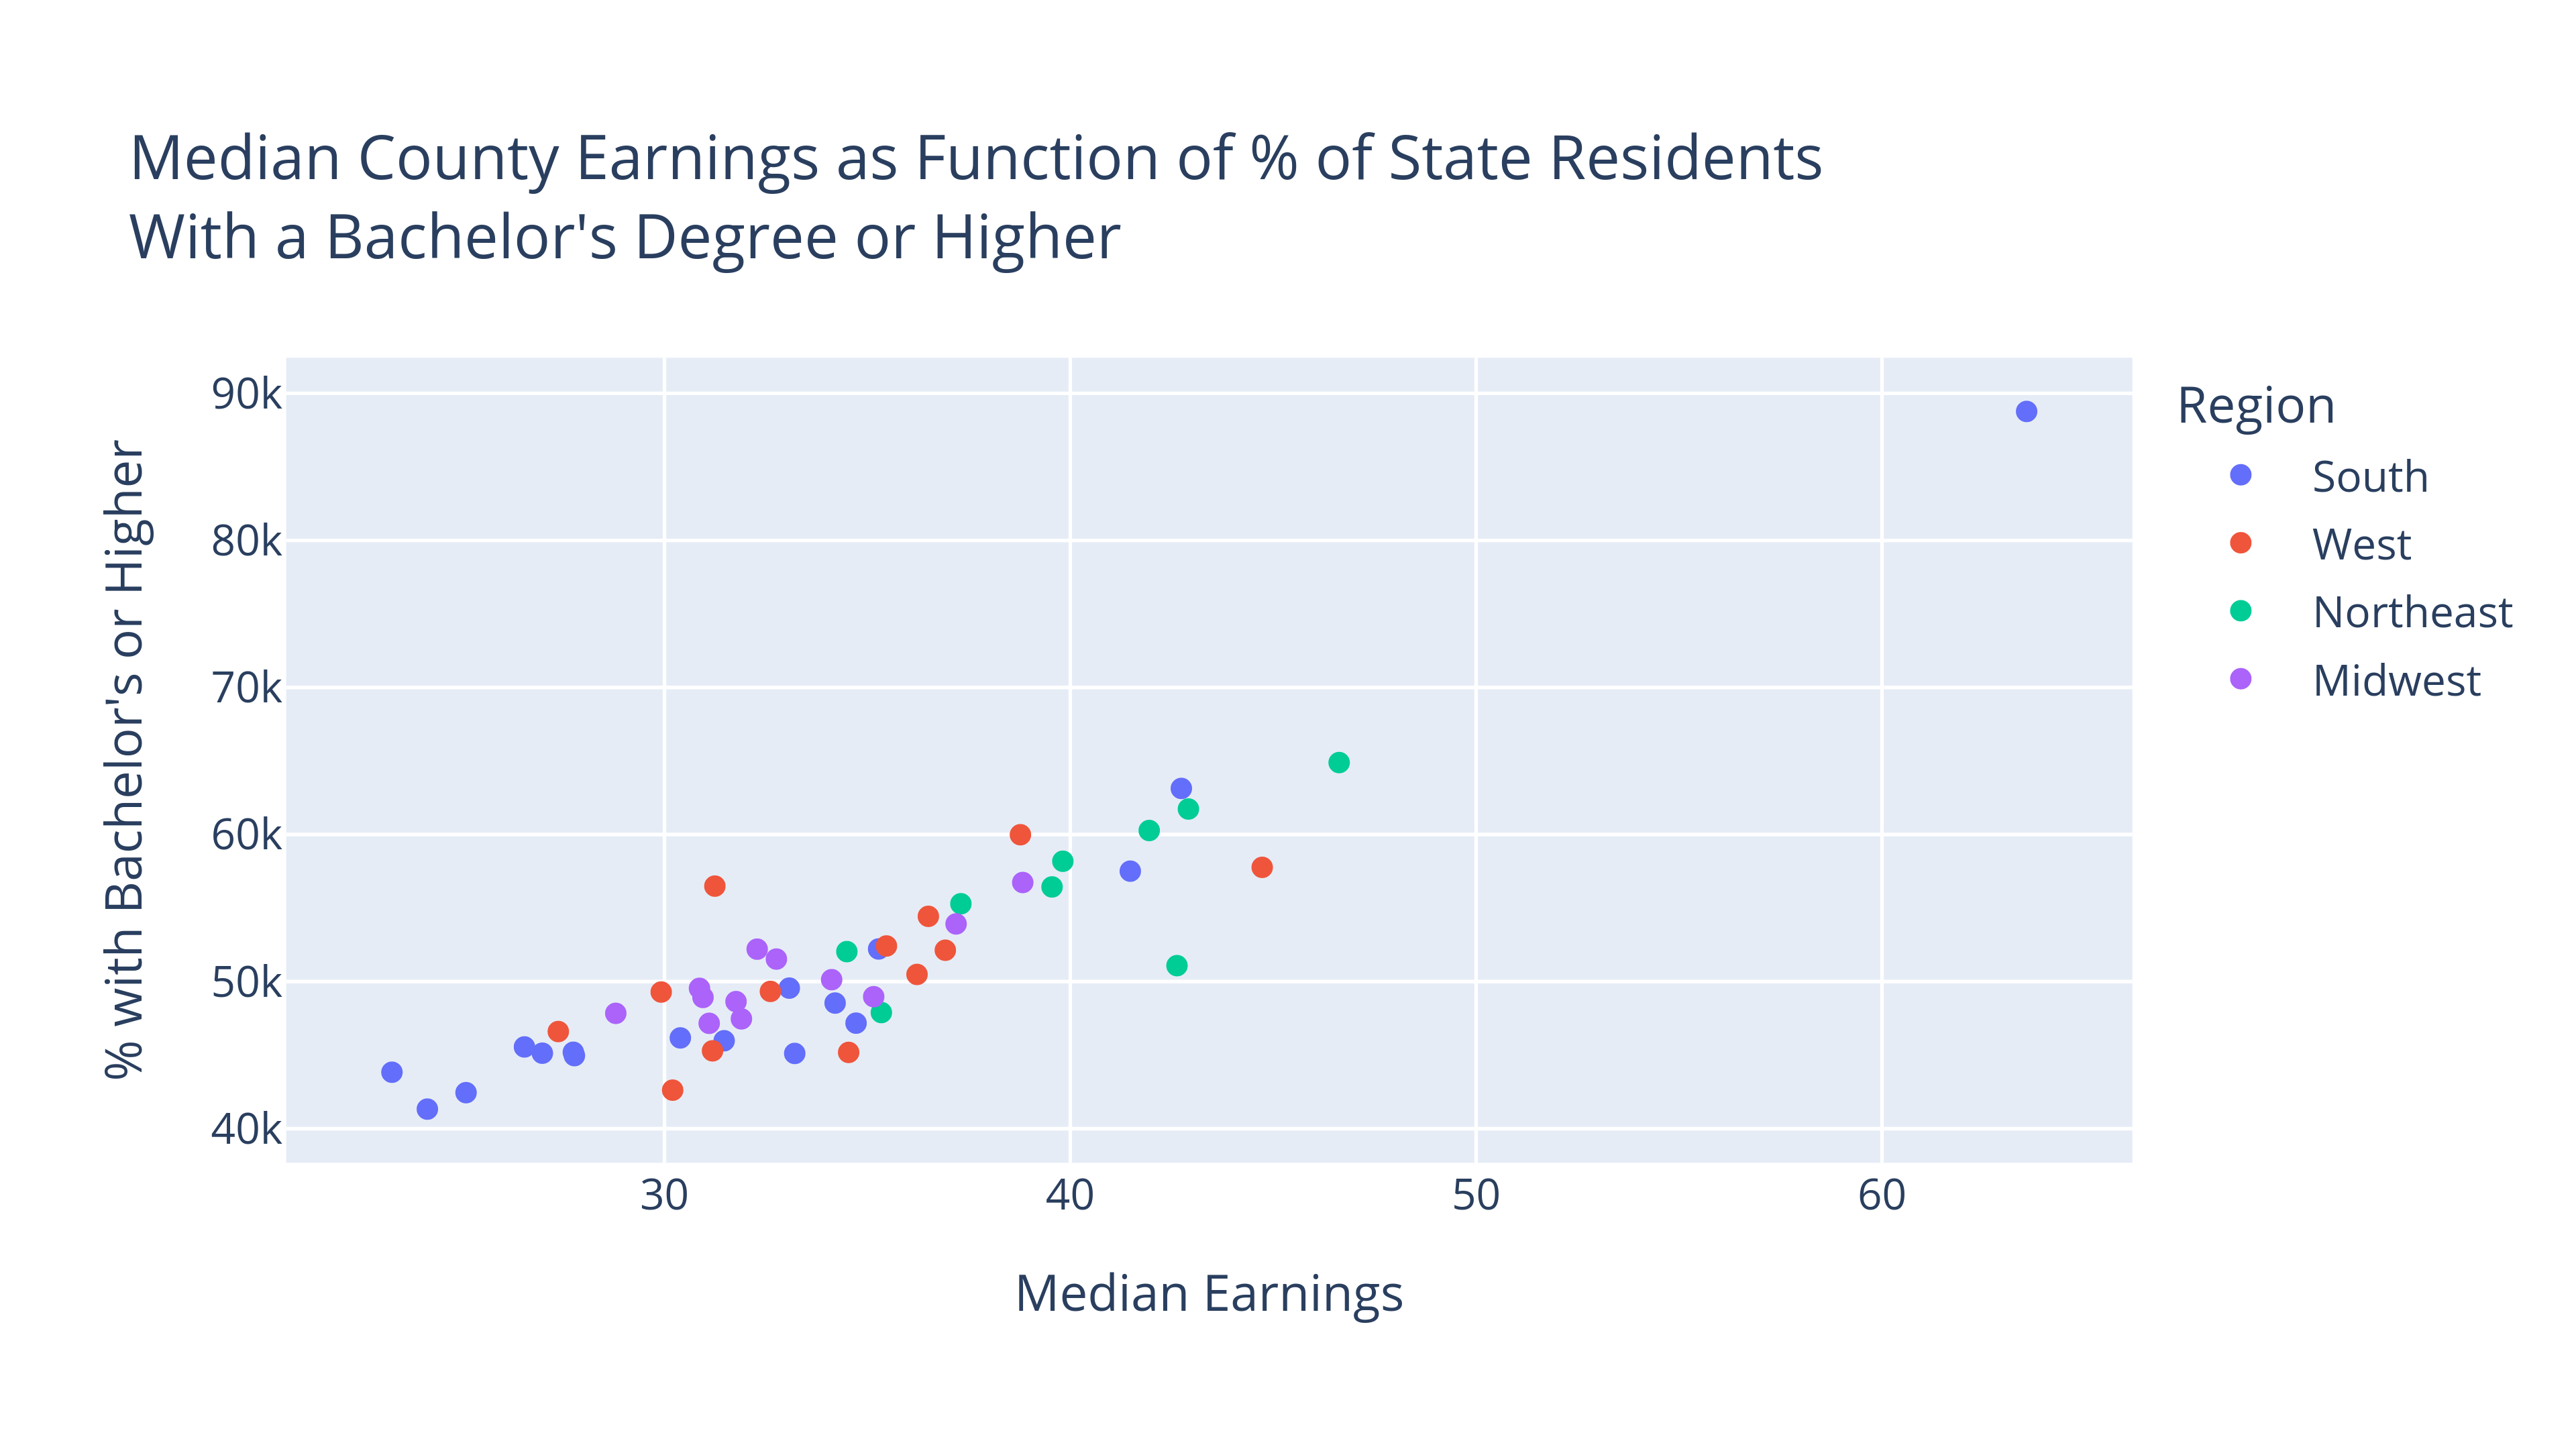

In [112]:
fig_smib_scatter = px.scatter(
    df_smib, x = "Pct_With_Bachelors_Degree", 
           y = 'Median_Earnings_for_Total_25plus_Population',
           color = 'Region', hover_data = 'NAME',
    title = "Median County Earnings as Function of % of State \
Residents<br>With a Bachelor's Degree or Higher").update_layout(
    xaxis_title = 'Median Earnings', yaxis_title = "% with Bachelor's \
or Higher")
wadi(fig_smib_scatter, 'Charts/state_ba_pct_earnings_scatter',
     display_type = display_type)

DC has a far higher median income *and* percentage of residents with bachelor's degrees than any state. Therefore, as it constitutes an outlier, I'll go ahead and remove it from our dataset.

In [113]:
df_smib.query("NAME != 'District of Columbia'", inplace = True)

Here's an updated scatter plot without DC:

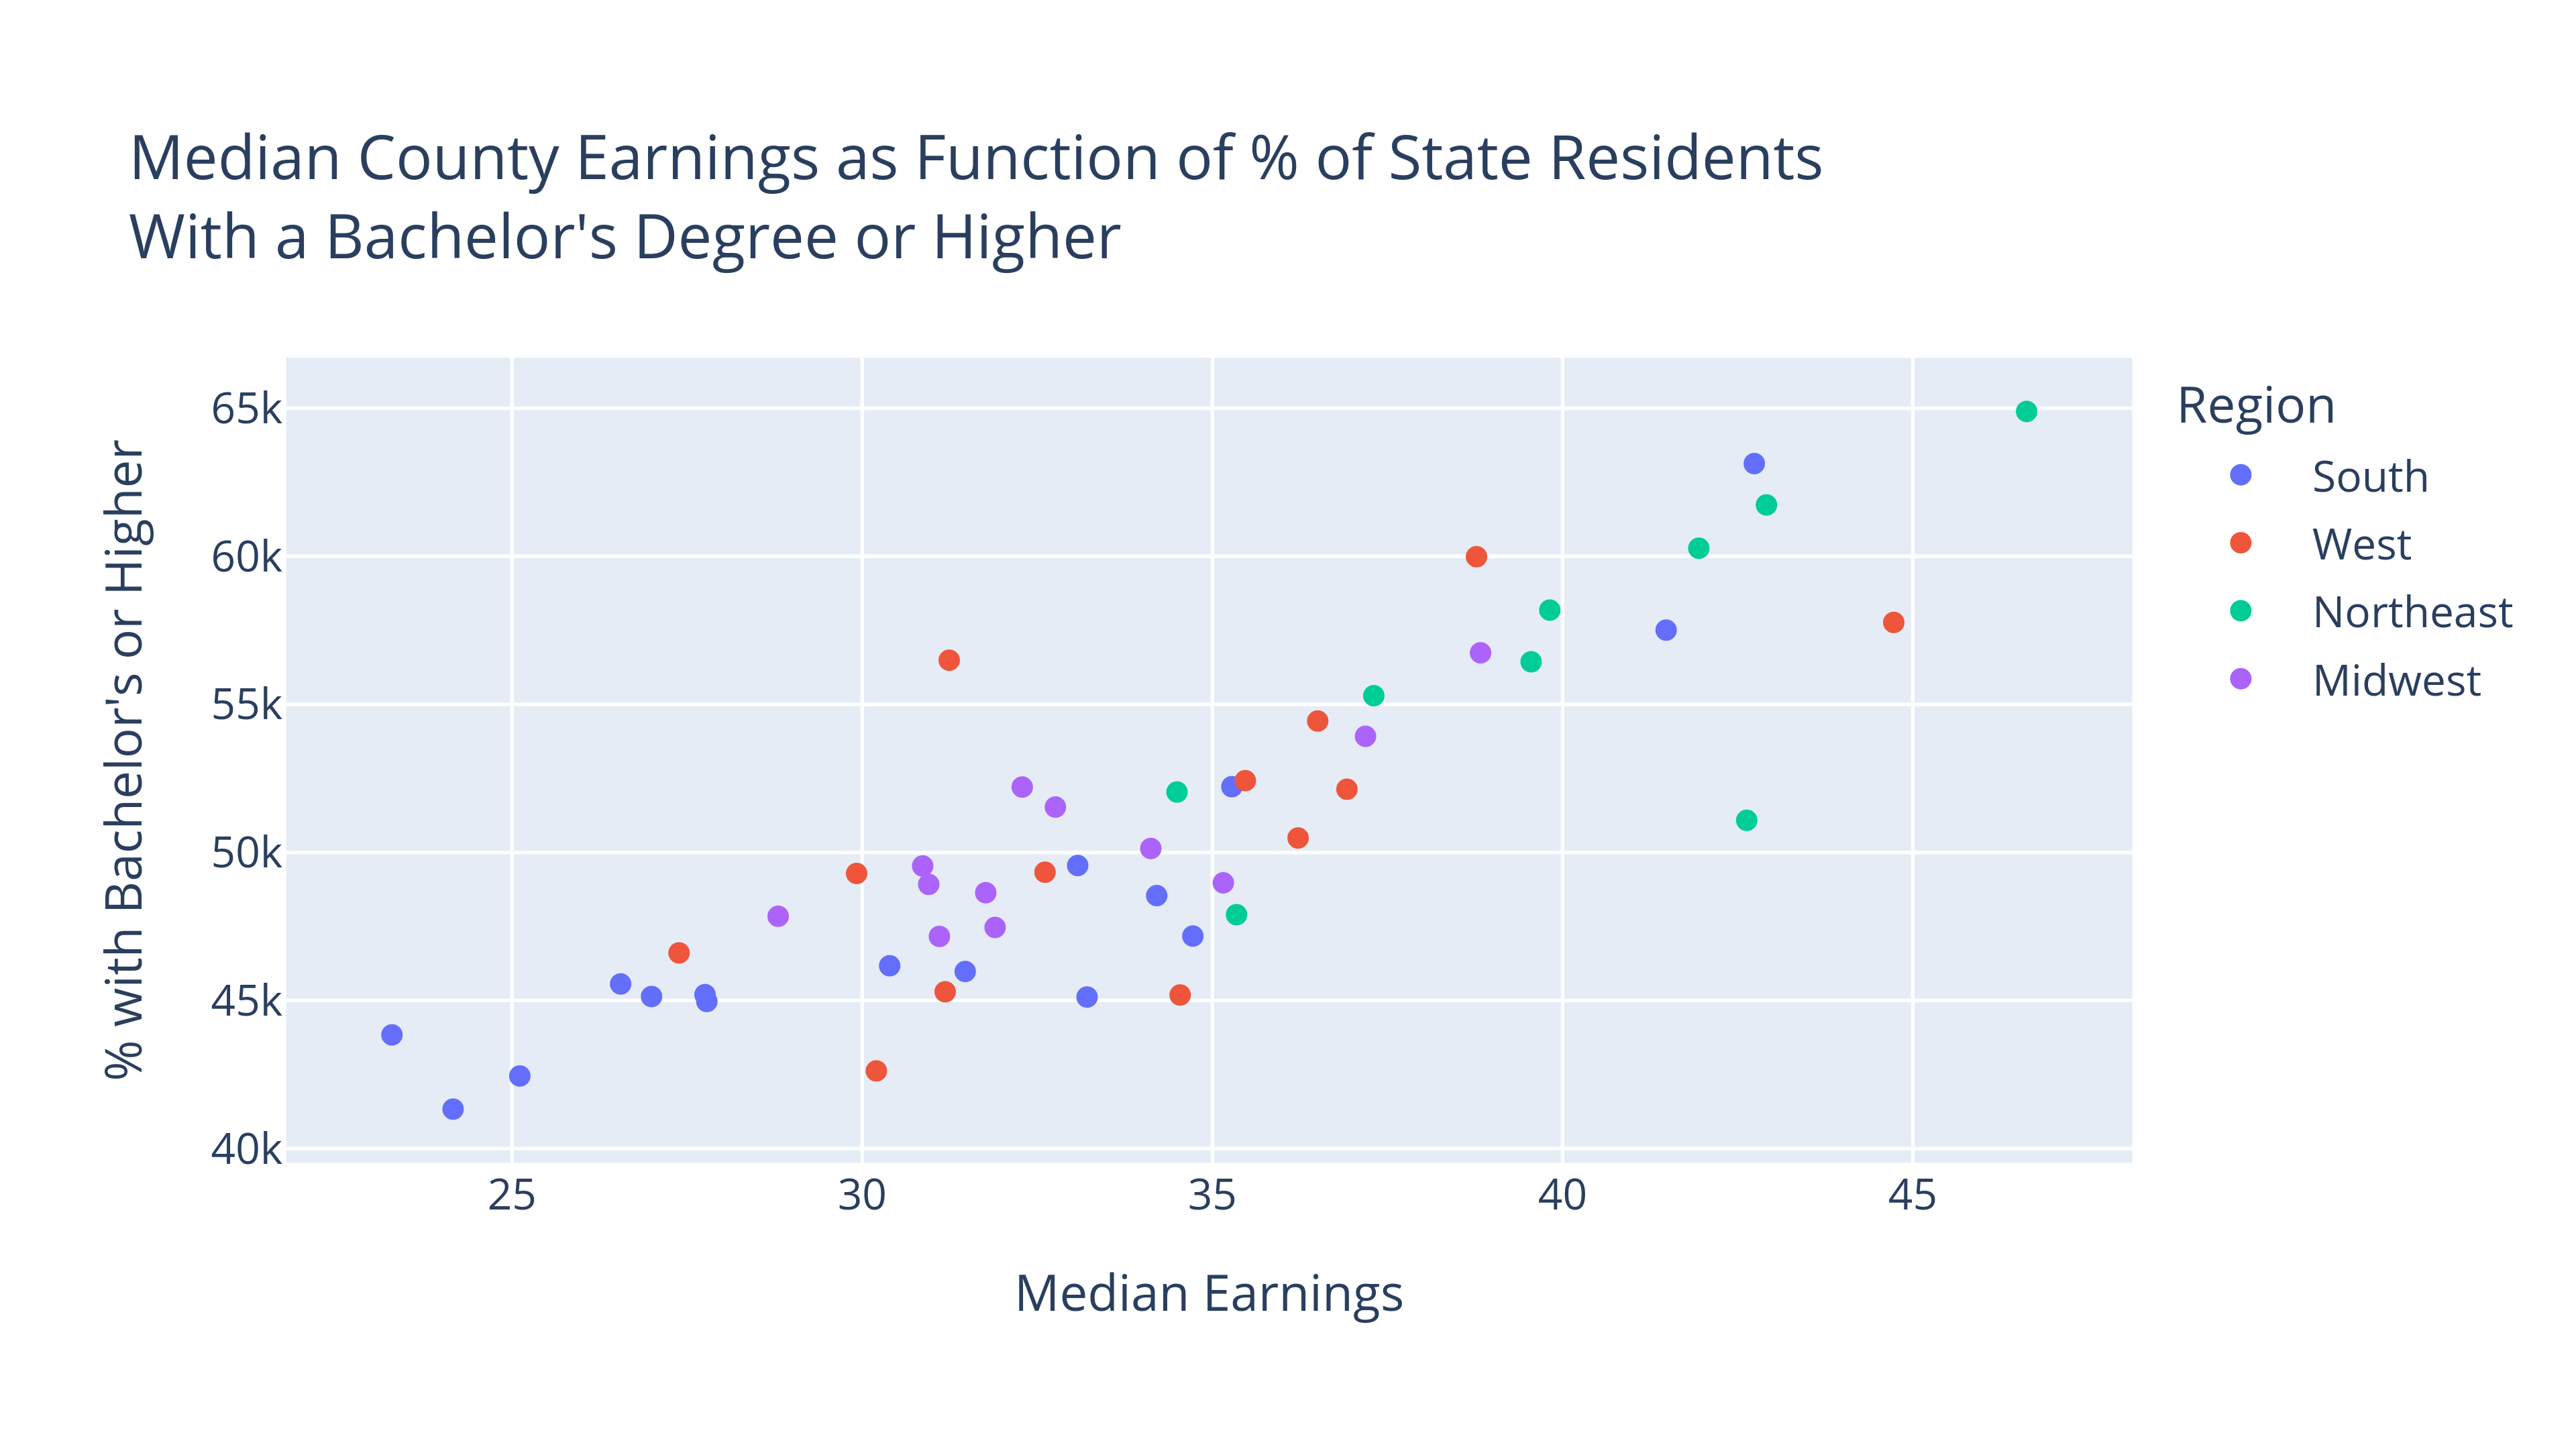

In [114]:
fig_smib_scatter = px.scatter(
    df_smib, x = "Pct_With_Bachelors_Degree", 
           y = 'Median_Earnings_for_Total_25plus_Population',
           color = 'Region', hover_data = 'NAME',
    title = "Median County Earnings as Function of % of State \
Residents<br>With a Bachelor's Degree or Higher").update_layout(
    xaxis_title = 'Median Earnings', yaxis_title = "% with Bachelor's \
or Higher")
wadi(fig_smib_scatter, 'Charts/state_ba_pct_earnings_scatter',
     display_type = display_type)

To me, the relationship between our independent and dependent variables appears quite linear; however, I ultimately found that a squared version of the 'Pct_With_Bachelors_Degree' field ended up having higher predictive power than the non-squared version.

In [115]:
df_smib['Pct_With_Bachelors_Degree_Squared'] = (
    df_smib['Pct_With_Bachelors_Degree']**2)
df_smib.head()

NAME  Total_Population  \
0     Alabama           5054253   
1      Alaska            733971   
2     Arizona           7268175   
3    Arkansas           3032651   
4  California          39242785   

   Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
0                                            3448302                                            
1                                             487903                                            
2                                            4990633                                            
3                                            2043779                                            
4                                           26941198                                            

   ...  Pct_With_Bachelors_Degree  Region  Pct_With_Bachelors_Degree_Squared  
0  ...                  27.755139   South                         770.347720  
1  ...                  31.242276    West                         976.079786  
2  ...                  32.610332    West                        1063.433766  
3  ...                  25.111375   South                         630.581133  
4  ...                  36.503058    West                        1332.473208  

[5 rows x 16 columns]

## Performing a linear regression:

First, we'll try building a regression model that includes bachelor's degree percentages; a squared version of this percentage; and our Region field.

In [116]:
smib_lr_1 = smf.ols(formula = "Median_Earnings_for_Total_\
25plus_Population ~ Pct_With_Bachelors_Degree_Squared + \
Pct_With_Bachelors_Degree + Region",
    data = df_smib) 
smib_lr_results_1 = smib_lr_1.fit()
smib_lr_results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median_Earnings_for_Total_25plus_Population   R-squared:                       0.764
Model:                                                     OLS   Adj. R-squared:                  0.737
Method:                                          Least Squares   F-statistic:                     28.47
Date:                                         Mon, 10 Feb 2025   Prob (F-statistic):           9.27e-13
Time:                                                 21:49:22   Log-Likelihood:                -466.59
No. Observations:                                           50   AIC:                             945.2
Df Residuals:                                               44   BIC:                             956.7
Df Model:                                                    5                                         
Covariance Type:                                     nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          4.782e+04   1.53e+04      3.134      0.003    1.71e+04    7.86e+04
Region[T.Northeast]                -824.2885   1508.486     -0.546      0.588   -3864.442    2215.865
Region[T.South]                   -1632.7421   1198.674     -1.362      0.180   -4048.511     783.027
Region[T.West]                     -689.3360   1178.346     -0.585      0.562   -3064.136    1685.464
Pct_With_Bachelors_Degree_Squared    22.4137     12.595      1.780      0.082      -2.969      47.796
Pct_With_Bachelors_Degree          -670.3622    875.607     -0.766      0.448   -2435.032    1094.308
==============================================================================
Omnibus:                        4.800   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.691
Skew:                          -0.110   Prob(JB):                       0.0581
Kurtosis:                       4.638   Cond. No.                     4.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Only the intercept is statistically significant! Is our model doomed? Not at all--we just need to reduce the number of predictors. Let's see what happens when we remove the 'Pct_With_Bachelors_Degree' predictor, as its p-value is far higher than its squared version:

In [117]:
smib_lr_1 = smf.ols(formula = "Median_Earnings_for_Total_\
25plus_Population ~ Pct_With_Bachelors_Degree_Squared + Region",
    data = df_smib) 
smib_lr_results_1 = smib_lr_1.fit()
smib_lr_results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median_Earnings_for_Total_25plus_Population   R-squared:                       0.761
Model:                                                     OLS   Adj. R-squared:                  0.739
Method:                                          Least Squares   F-statistic:                     35.77
Date:                                         Mon, 10 Feb 2025   Prob (F-statistic):           1.91e-13
Time:                                                 21:49:26   Log-Likelihood:                -466.92
No. Observations:                                           50   AIC:                             943.8
Df Residuals:                                               45   BIC:                             953.4
Df Model:                                                    4                                         
Covariance Type:                                     nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          3.621e+04   1693.707     21.381      0.000    3.28e+04    3.96e+04
Region[T.Northeast]                -554.2037   1459.895     -0.380      0.706   -3494.584    2386.177
Region[T.South]                   -1304.8976   1114.414     -1.171      0.248   -3549.443     939.648
Region[T.West]                     -609.9461   1168.364     -0.522      0.604   -2963.153    1743.261
Pct_With_Bachelors_Degree_Squared    12.8269      1.345      9.538      0.000      10.118      15.535
==============================================================================
Omnibus:                        4.113   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                4.268
Skew:                          -0.110   Prob(JB):                        0.118
Kurtosis:                       4.414   Cond. No.                     5.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The Pct_With_Bachelors_Degree_Squared field is now a statistically significant predictor. However, all of the 'Region' categories are still insignificant, so I'll go ahead and remove them. Doing so ended up increasing the adjusted R^2 out of my regression:

In [118]:
smib_lr_1 = smf.ols(formula = "Median_Earnings_for_Total_\
25plus_Population ~ Pct_With_Bachelors_Degree_Squared",
    data = df_smib) 
smib_lr_results_1 = smib_lr_1.fit()
smib_lr_results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median_Earnings_for_Total_25plus_Population   R-squared:                       0.753
Model:                                                     OLS   Adj. R-squared:                  0.748
Method:                                          Least Squares   F-statistic:                     146.6
Date:                                         Mon, 10 Feb 2025   Prob (F-statistic):           3.35e-16
Time:                                                 21:49:28   Log-Likelihood:                -467.68
No. Observations:                                           50   AIC:                             939.4
Df Residuals:                                               48   BIC:                             943.2
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          3.526e+04   1339.845     26.319      0.000    3.26e+04     3.8e+04
Pct_With_Bachelors_Degree_Squared    13.0572      1.078     12.110      0.000      10.889      15.225
==============================================================================
Omnibus:                        3.676   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.438
Skew:                          -0.126   Prob(JB):                        0.179
Kurtosis:                       4.260   Cond. No.                     4.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [119]:
df_smib_pred_vs_actual = df_smib.copy()[
['NAME', 'Median_Earnings_for_Total_25plus_Population',
 'Pct_With_Bachelors_Degree_Squared', 'Region']]
df_smib_pred_vs_actual['Pred_Val'] = smib_lr_results_1.predict(
    df_smib_pred_vs_actual[['Pct_With_Bachelors_Degree_Squared']])
df_smib_pred_vs_actual
df_smib_pred_vs_actual['Actual-Pred'] = (
    df_smib_pred_vs_actual['Median_Earnings_for_Total_25plus_Population'] - 
    df_smib_pred_vs_actual['Pred_Val'])

In [120]:
df_smib_pred_vs_actual.sort_values(
    'Actual-Pred', ascending = False).head(8)

NAME  Median_Earnings_for_Total_25plus_Population  \
1          Alaska                                        56492   
47     Washington                                        59987   
20       Maryland                                        63133   
34   North Dakota                                        52208   
30     New Jersey                                        61736   
50        Wyoming                                        49290   
49      Wisconsin                                        51533   
29  New Hampshire                                        58184   

    Pct_With_Bachelors_Degree_Squared     Region      Pred_Val  Actual-Pred  
1                          976.079786       West  48008.674448  8483.325552  
47                        1503.152620       West  54890.768989  5096.231011  
20                        1826.396975      South  59111.434646  4021.565354  
34                        1042.311655    Midwest  48873.477097  3334.522903  
30                        1841.314202  Northeast  59306.211838  2429.788162  
50                         895.224605       West  46952.932310  2337.067690  
49                        1073.109104    Midwest  49275.605504  2257.394496  
29                        1585.362528  Northeast  55964.200072  2219.799928

In [121]:
df_smib_pred_vs_actual.sort_values(
    'Actual-Pred').head(8)

NAME  Median_Earnings_for_Total_25plus_Population  \
45         Vermont                                        51085   
26         Montana                                        45186   
31      New Mexico                                        42621   
9          Florida                                        45117   
33  North Carolina                                        47176   
19           Maine                                        47897   
5         Colorado                                        57768   
12           Idaho                                        45294   

    Pct_With_Bachelors_Degree_Squared     Region      Pred_Val  Actual-Pred  
45                        1817.202826  Northeast  58991.384818 -7906.384818  
26                        1192.942470       West  50840.293537 -5654.293537  
31                         912.149489       West  47173.923887 -4552.923887  
9                         1102.923670      South  49664.900210 -4547.900210  
33                        1205.528668      South  51004.634015 -3828.634015  
19                        1249.235138  Northeast  51575.318064 -3678.318064  
5                         2000.592904       West  61385.945451 -3617.945451  
12                         972.459715       West  47961.406465 -2667.406465

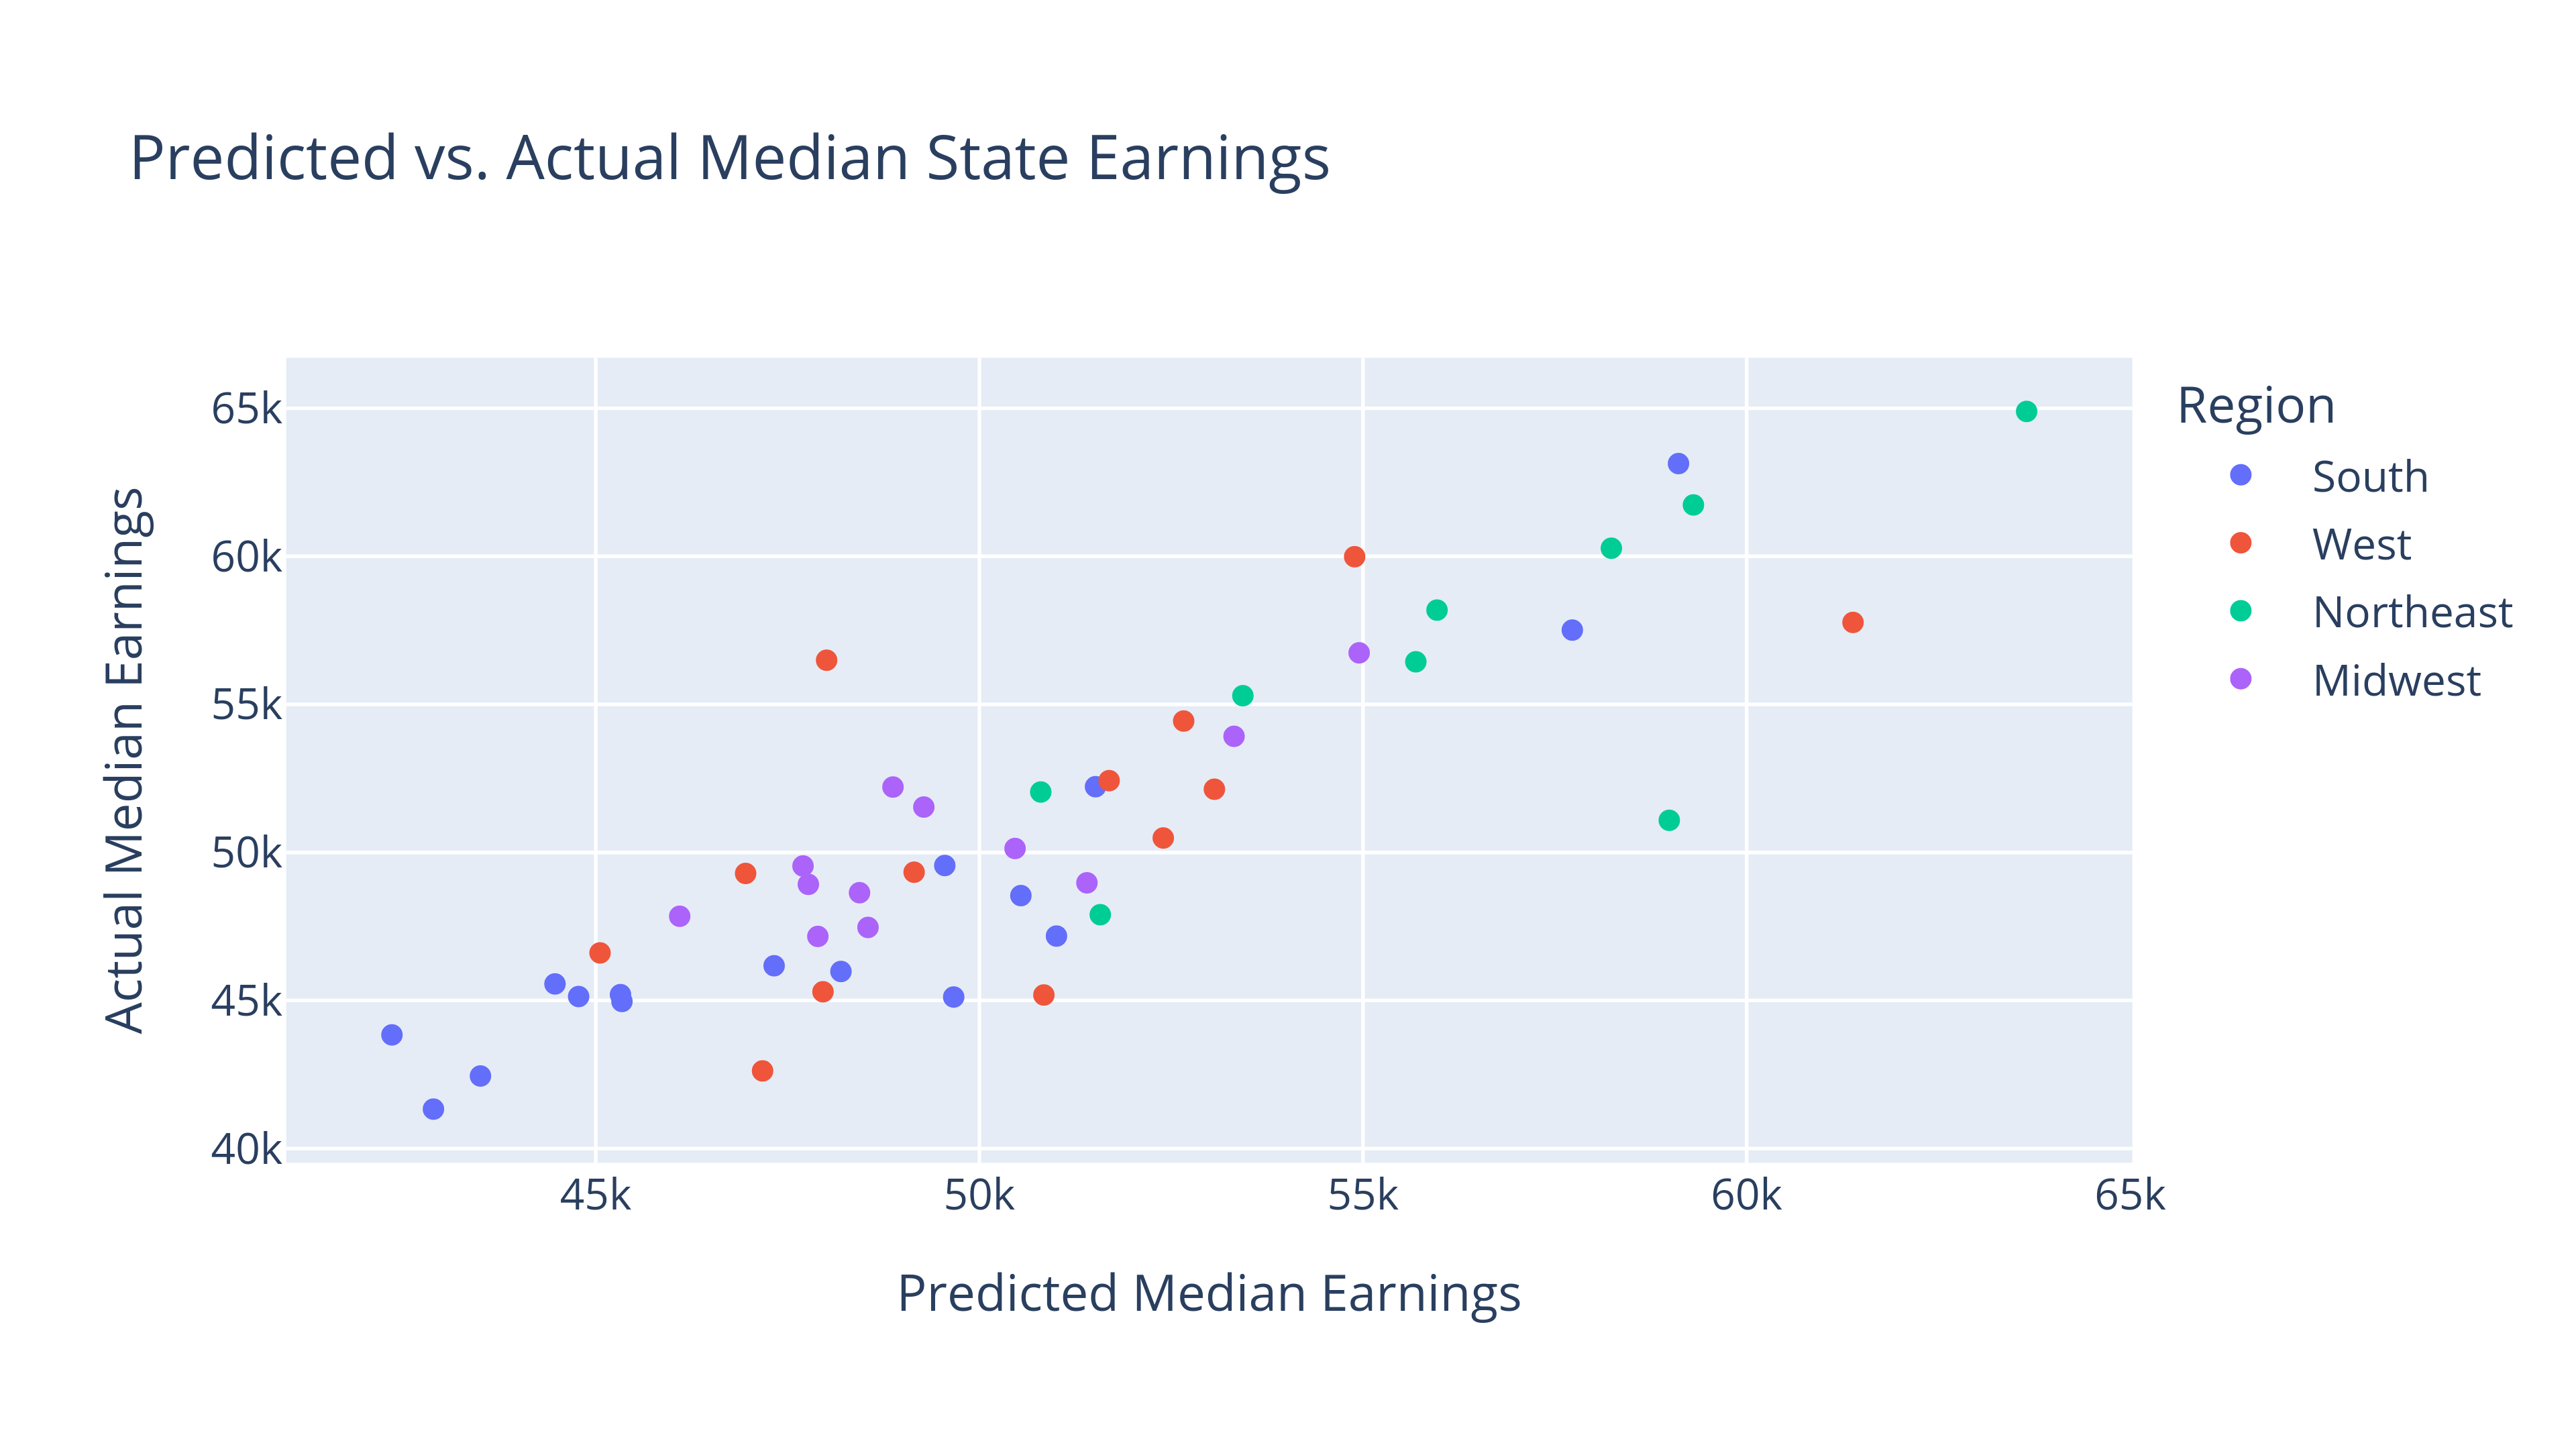

In [128]:
fig_smib_pred_vs_actual = px.scatter(
    df_smib_pred_vs_actual, x = 'Pred_Val', 
           y = 'Median_Earnings_for_Total_25plus_Population',
    color = 'Region', hover_data = 'NAME', 
    title = "Predicted vs. Actual Median State Earnings").update_layout(
    xaxis_title = 'Predicted Median Earnings', 
    yaxis_title = 'Actual Median Earnings')
wadi(fig_smib_pred_vs_actual, 'Charts/smib_pred_vs_actual',
     display_type=display_type)

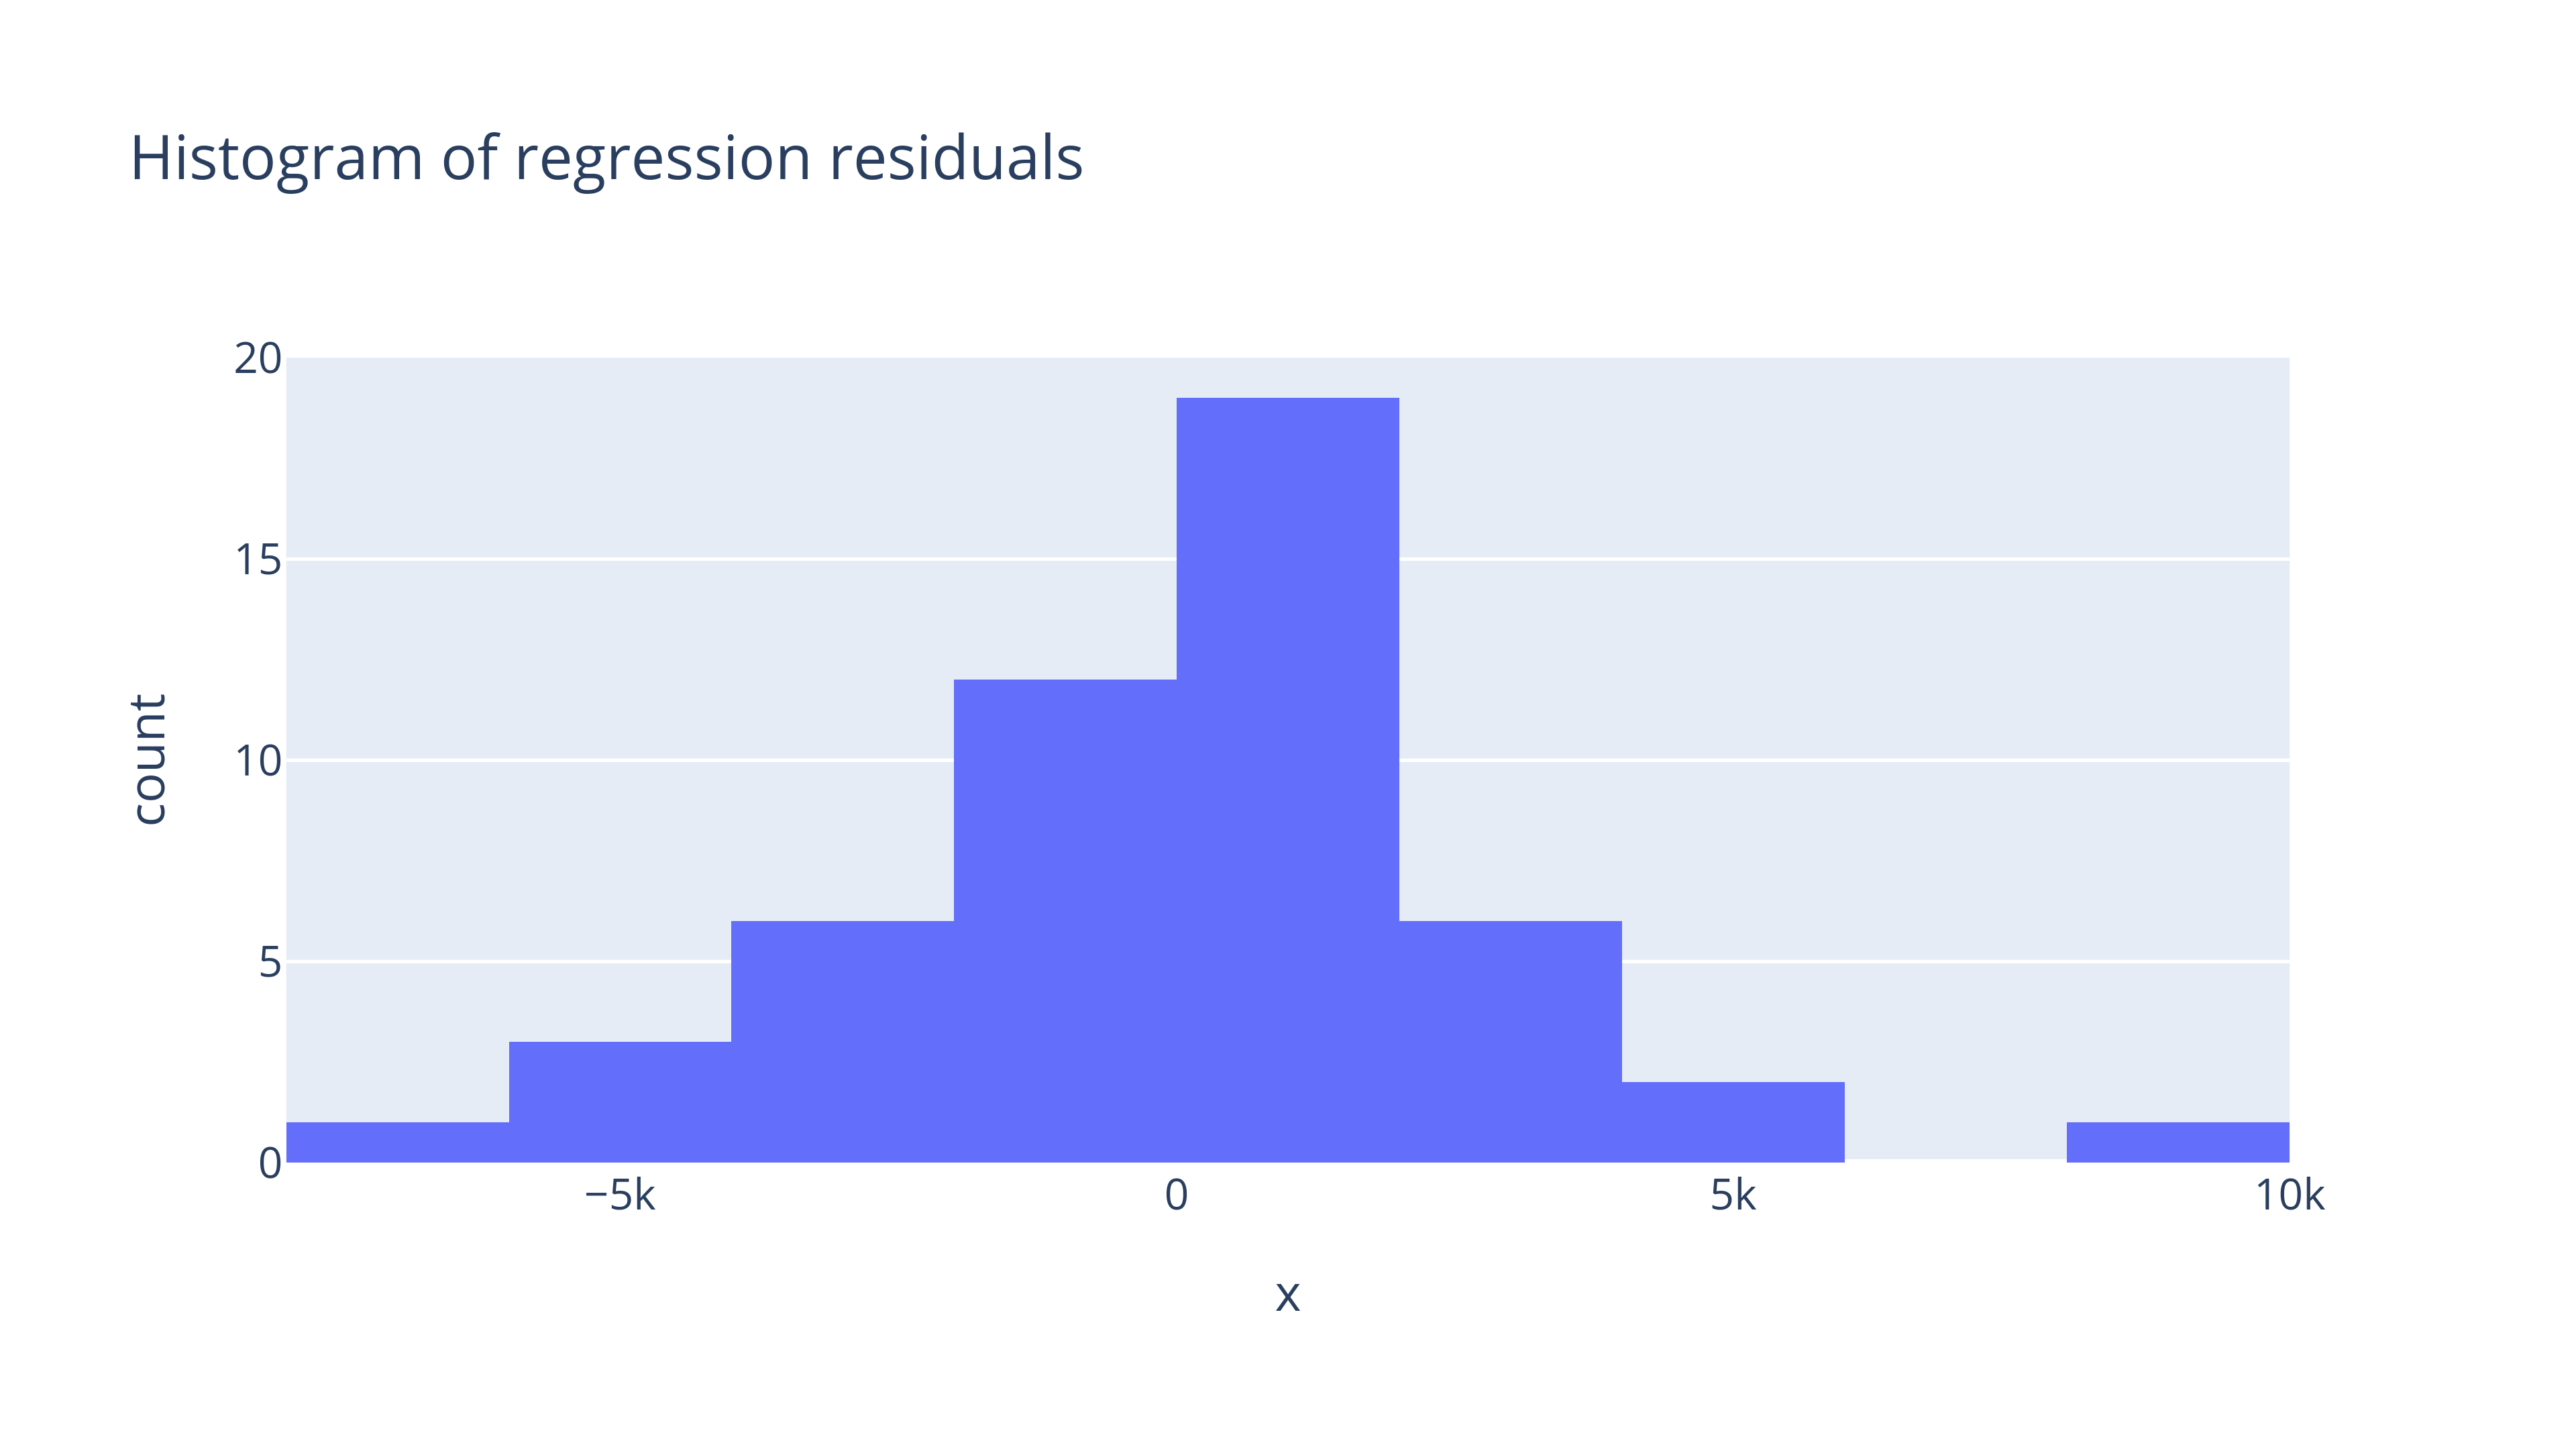

In [130]:
fig_smib_hist = px.histogram(
    x = smib_lr_results_1.resid,
title = 'Histogram of regression residuals')
wadi(fig_smib_hist, 'Charts/smib_residual',
     display_type=display_type)

In [131]:
sms.omni_normtest(
    smib_lr_results_1.resid)

NormaltestResult(statistic=np.float64(3.6759444784110493), pvalue=np.float64(0.15913979659171434))

## Comparing median earnings for different education levels

Importing national medians (which will prove more useful for certain analyses than county- or state-level medians):

In [41]:
df_nmib = pd.read_csv(
    '../Census_Data_Imports/Datasets/education_and_earnings_national.csv')
df_nmib

Year  us           NAME  ...  Median_Earnings_Bachelors_Degree  \
0  2023   1  United States  ...                             67849   

   Median_Earnings_Postgraduate  Pct_With_Bachelors_Degree  
0                         88719                   35.00095  

[1 rows x 16 columns]

In [133]:
df_cmib_ec = df_cmib.copy() # ec = 'earnings_comparison'

In [43]:
for col in median_earnings_cols:
    df_cmib_ec.query(f'`{col}` >= 0', inplace = True)
print(len(df_cmib_ec))

# The following code creates a new set of columns that determines
# the percentage change in median earnings between certain educational
# attainment categories.

for df in [df_nmib, df_cmib_ec]:

    df['Pct_Median_Earnings_Increase_non_HS_to_HS'] = (
    100*(df['Median_Earnings_HS'] / 
         df['Median_Earnings_Less_Than_HS'] - 1))
    
    df['Pct_Median_Earnings_Increase_HS_to_Bachelors'] = (
    100*(df['Median_Earnings_Bachelors_Degree'] / 
         df['Median_Earnings_HS'] - 1))
    
    df['Pct_Median_Earnings_Increase_Bachelors_to_Postgraduate'] = (
    100*(df['Median_Earnings_Postgraduate'] / 
         df['Median_Earnings_Bachelors_Degree'] - 1))
    
    df['Pct_Median_Earnings_Increase_HS_to_Postgraduate'] = (
    100*(df['Median_Earnings_Postgraduate'] / 
         df['Median_Earnings_HS'] - 1))
  
    
df_nmib

2869


Year  us           NAME  ...  Pct_Median_Earnings_Increase_HS_to_Bachelors  \
0  2023   1  United States  ...                                     74.918147   

   Pct_Median_Earnings_Increase_Bachelors_to_Postgraduate  \
0                                          30.759481        

   Pct_Median_Earnings_Increase_HS_to_Postgraduate  
0                                        128.72206  

[1 rows x 20 columns]

## Comparing median earnings values at both the national level and the median county level

(Expound more on this section--my guess is that the national HS-bachelor's increase is higher than the county-level one because people with bachelor's degrees are more likely to be in higher-earning counties, thus accentuating the difference in earnings; thus, just comparing national HS and bachelor's salaries may not be as accurate as comparing county-level readings in which people are in similar economic regions. However, you could also argue that the ability of people to move between counties means that the national-level % differences are still valid; people with bachelor's degrees might simply choose to move to higher-earning counties, and that's certainly relevant for our analysis.)

In [155]:
df_national_earnings_by_ed_level = df_nmib[median_earnings_cols].transpose(
).reset_index().rename(
    columns = {'index':'Category', 0:'Median Earnings'})

# The following code uses both str.replace() and replace() to 
# convert the education levels in the Category field to a more concise
# and readable format.
df_national_earnings_by_ed_level['Education Level'] = (
    df_national_earnings_by_ed_level['Category'].str.replace(
    'Median_Earnings_', '').str.replace('_',' ')).replace(
        {'for Total 25plus Population':'Total 25+ Population',
        'Bachelors Degree':"Bachelor's"})
df_national_earnings_by_ed_level

Category  Median Earnings  \
0  Median_Earnings_for_Total_25plus_Population            51184   
1                 Median_Earnings_Less_Than_HS            31492   
2                           Median_Earnings_HS            38789   
3                 Median_Earnings_Some_College            45840   
4             Median_Earnings_Bachelors_Degree            67849   
5                 Median_Earnings_Postgraduate            88719   

        Education Level  
0  Total 25+ Population  
1          Less Than HS  
2                    HS  
3          Some College  
4            Bachelor's  
5          Postgraduate

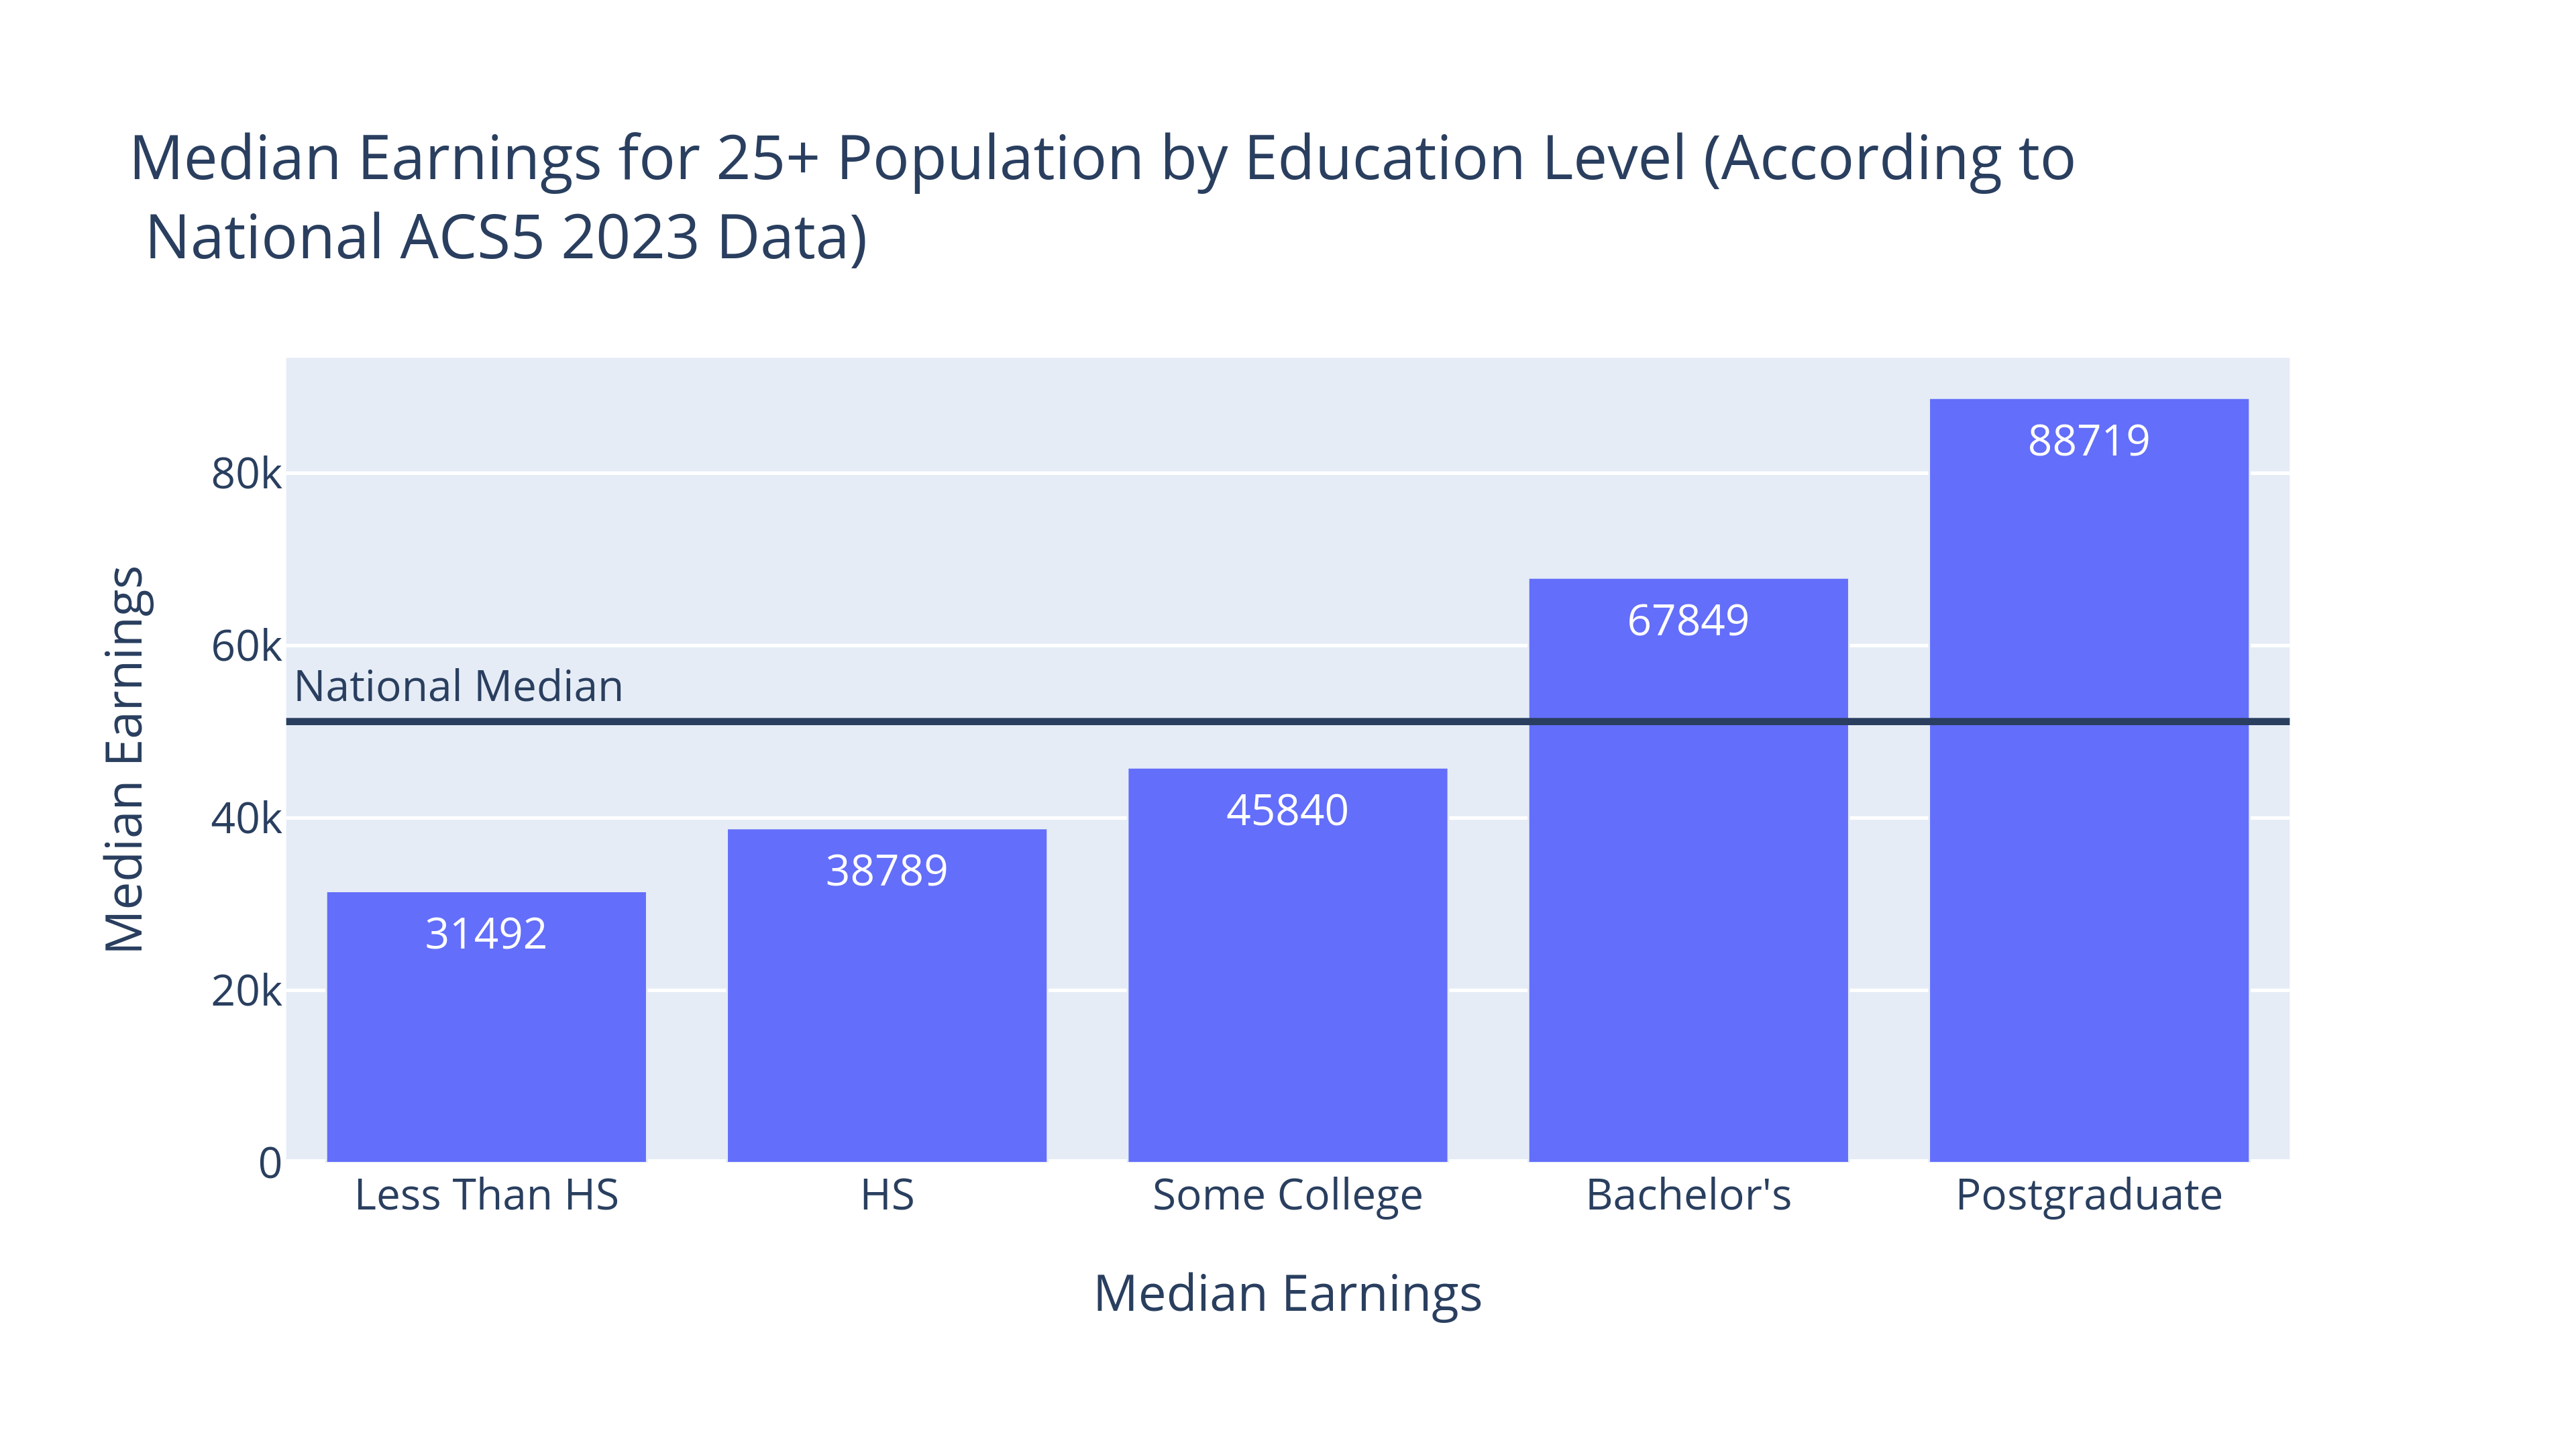

In [164]:
fig_national_median_earnings = px.bar(
    df_national_earnings_by_ed_level.query(
    "Category != 'Median_Earnings_for_Total_25plus_Population'"), 
       x = 'Education Level', y = 'Median Earnings', text_auto = '.0f',
      title = 'Median Earnings for 25+ Population by Education Level \
(According to<br> National ACS5 2023 Data)').update_layout(
    xaxis_title = 'Median Earnings')
fig_national_median_earnings.add_hline(
    y = df_national_earnings_by_ed_level.query("Category == \
'Median_Earnings_for_Total_25plus_Population'").iloc[0][
    'Median Earnings'], annotation_text = 'National Median',
annotation_position = 'top left')
wadi(fig_national_median_earnings, 'Charts/national_median_earnings',
     display_type=display_type)

In [134]:
df_county_earnings_by_ed_level = df_cmib_ec[median_earnings_cols].median(
).reset_index().rename(
    columns = {'index':'Category', 0:'Median Earnings'})
# The following code uses both str.replace() and replace() to 
# convert the education levels in the Category field to a more concise
# and readable format.
df_national_earnings_by_ed_level['Education Level'] = (
    df_national_earnings_by_ed_level['Category'].str.replace(
    'Median_Earnings_', '').str.replace('_',' ')).replace(
        {'for Total 25plus Population':'Total 25+ Population',
        'Bachelors Degree':"Bachelor's"})
df_county_earnings_by_ed_level

Category  Median_Earnings
0  Median_Earnings_for_Total_25plus_Population          43562.5
1                 Median_Earnings_Less_Than_HS          31167.0
2                           Median_Earnings_HS          37476.0
3                 Median_Earnings_Some_College          42268.0
4             Median_Earnings_Bachelors_Degree          55444.0
5                 Median_Earnings_Postgraduate          68500.5

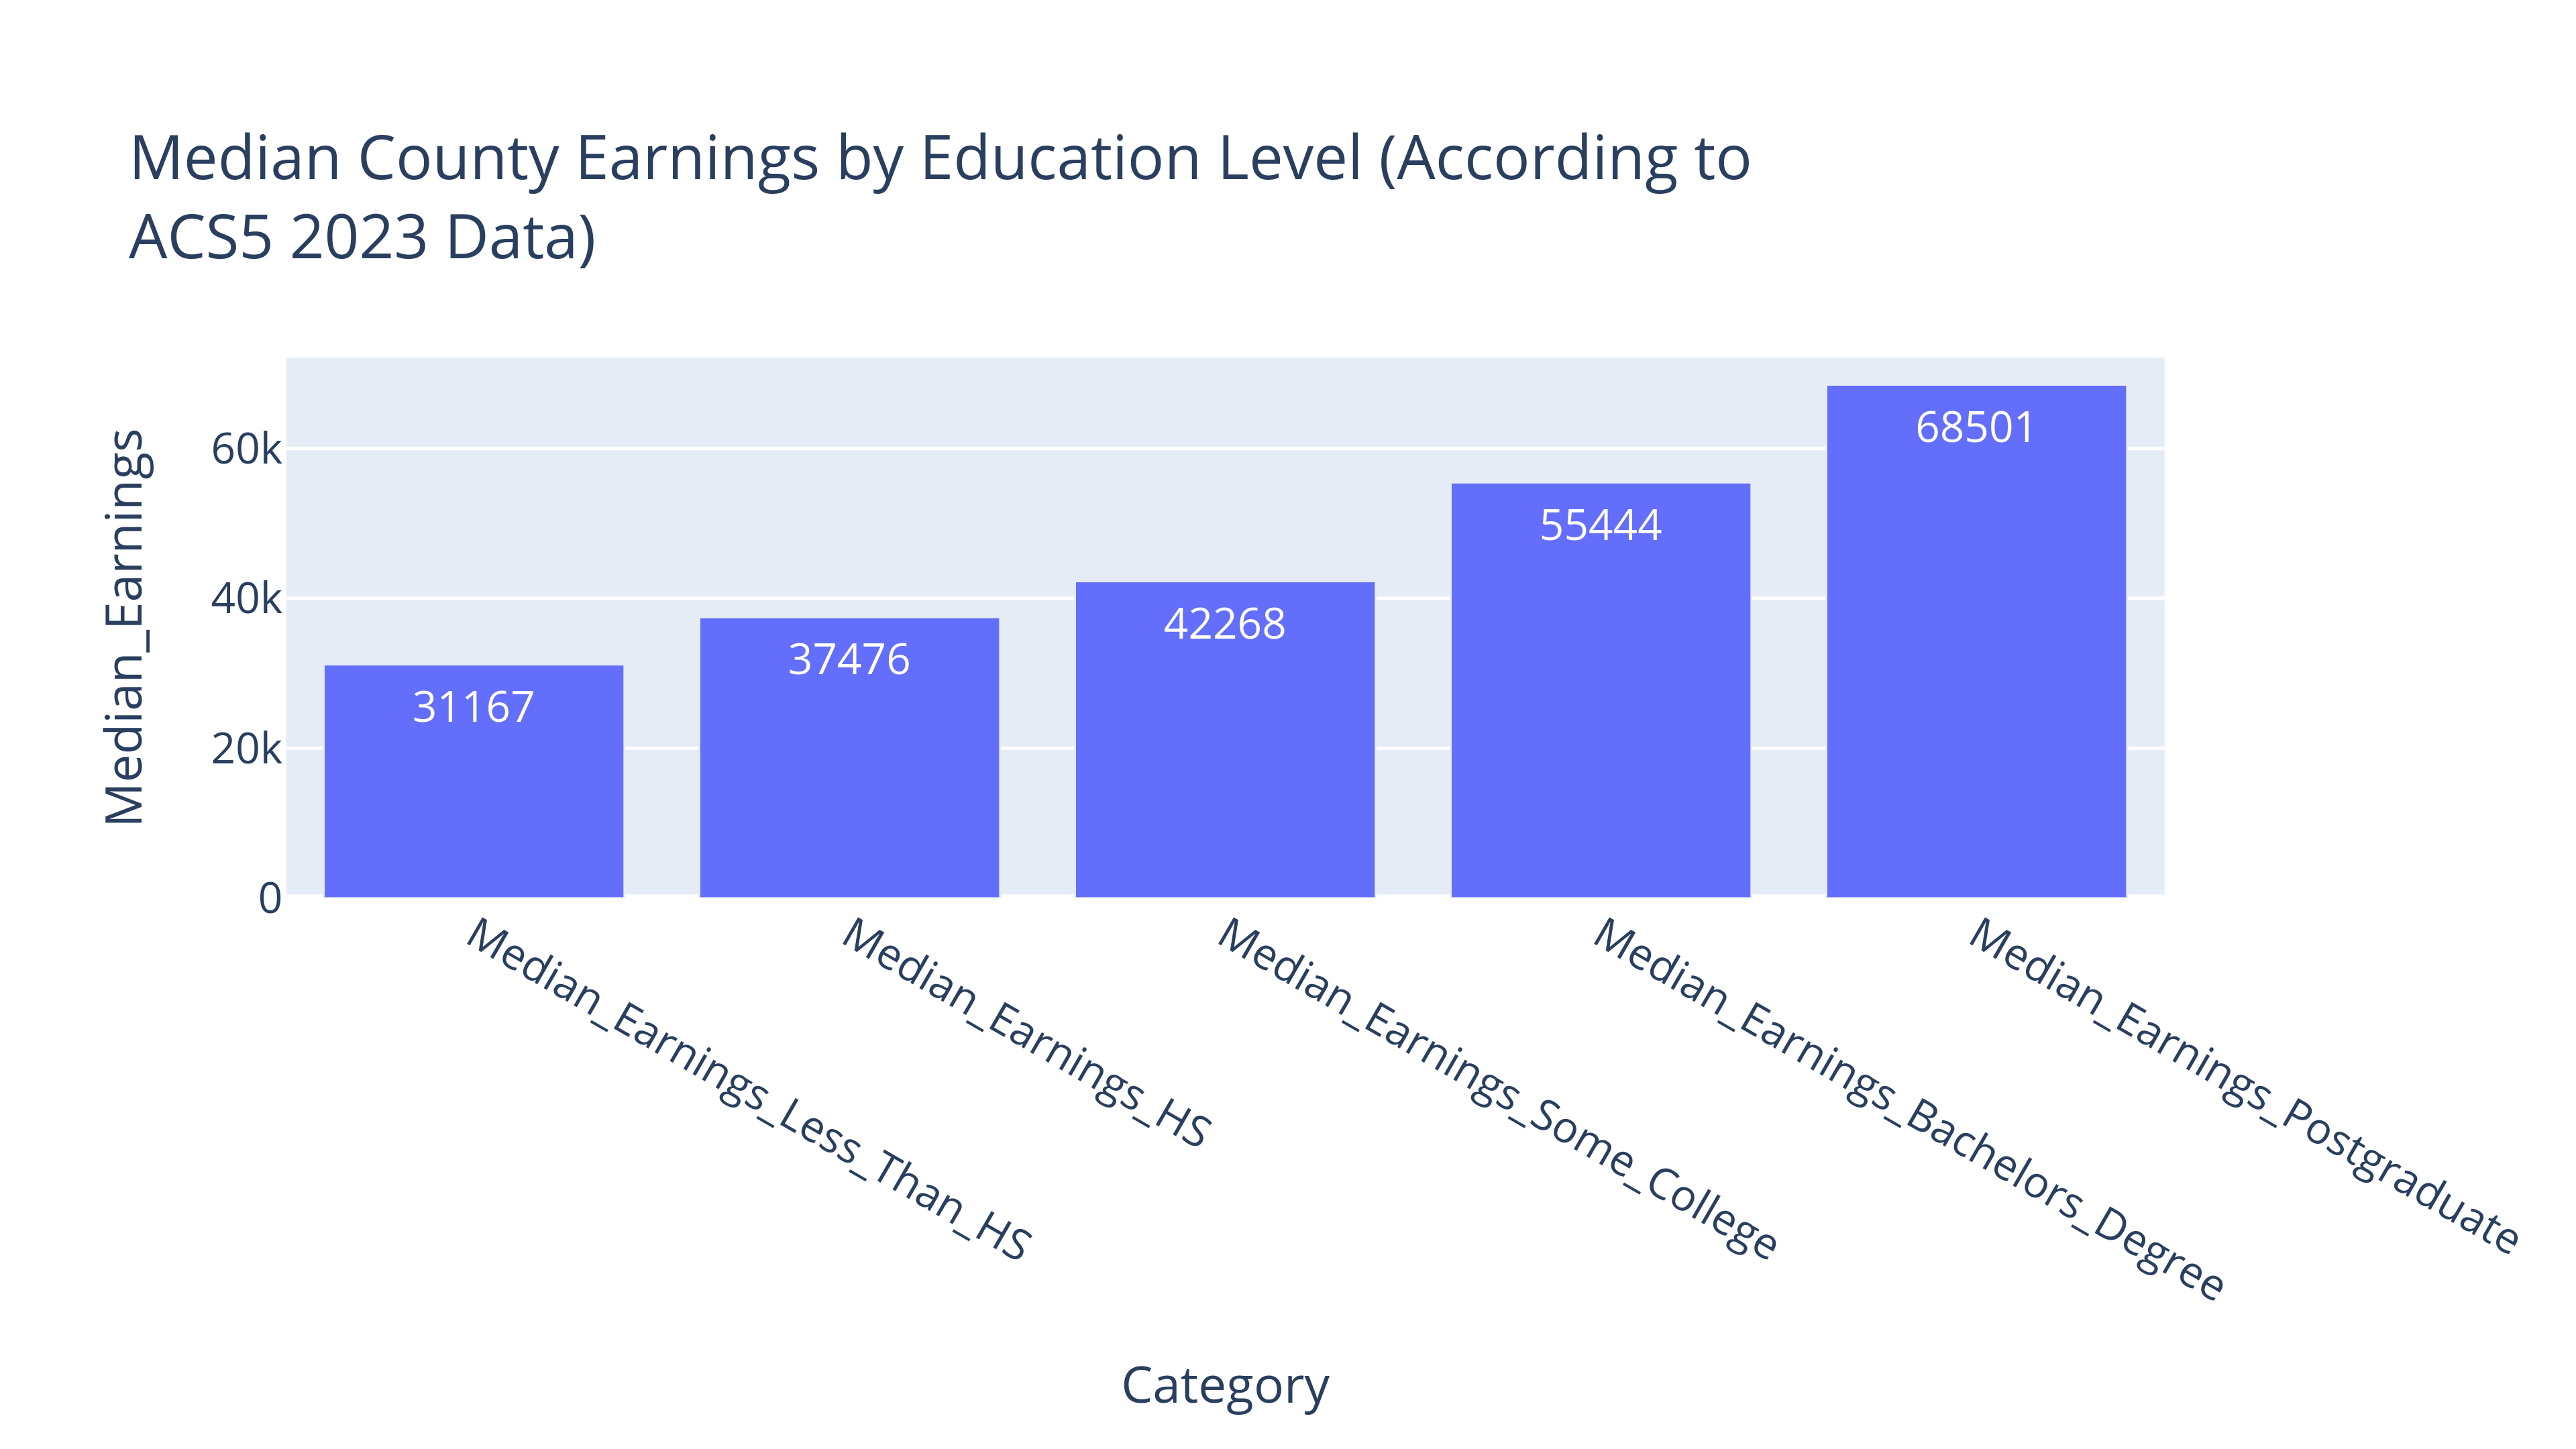

In [141]:
fig_county_median_earnings = px.bar(
    df_county_earnings_by_ed_level.query(
    "Category != 'Median_Earnings_for_Total_25plus_Population'"), 
       x = 'Category', y = 'Median_Earnings', text_auto = '.0f',
      title = 'Median County Earnings by Education Level (According to<br>\
ACS5 2023 Data)')
wadi(fig_county_median_earnings, 'Charts/county_median_earnings',
     display_type=display_type)

Identifying the regions with 50,000 or more residents that have the highest percentage difference in median incomes between bachelor's-degree holders and high-school graduates:

In [49]:
df_cmib_ec.query("Total_Population >= 50000").sort_values(
    'Pct_Median_Earnings_Increase_HS_to_Bachelors', 
                       ascending = False).head(8)

NAME  Total_Population  \
2828                  Arlington County, Virginia            235463   
224             San Francisco County, California            836321   
1860                   New York County, New York           1627788   
2917                   Alexandria city, Virginia            156788   
321   District of Columbia, District of Columbia            672079   
229               Santa Clara County, California           1903297   
2850                    Fairfax County, Virginia           1144474   
2874                    Loudoun County, Virginia            427082   

      Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
2828                                             173227                                            
224                                              669238                                            
1860                                            1260428                                            
2917                                             118944                                            
321                                              484406                                            
229                                             1338186                                            
2850                                             785190                                            
2874                                             278473                                            

      ...  Pct_Median_Earnings_Increase_HS_to_Bachelors  \
2828  ...                                    184.147394   
224   ...                                    169.921759   
1860  ...                                    166.556683   
2917  ...                                    161.109609   
321   ...                                    142.831086   
229   ...                                    135.489613   
2850  ...                                    132.574208   
2874  ...                                    130.743637   

      Pct_Median_Earnings_Increase_Bachelors_to_Postgraduate  \
2828                                          24.680860        
224                                           31.259632        
1860                                          25.568369        
2917                                          36.880795        
321                                           31.887702        
229                                           51.654176        
2850                                          35.004665        
2874                                          18.771629        

      Pct_Median_Earnings_Increase_HS_to_Postgraduate  
2828                                       254.277413  
224                                        254.298306  
1860                                       234.710880  
2917                                       257.408909  
321                                        220.264340  
229                                        257.129833  
2850                                       213.986031  
2874                                       174.057977  

[8 rows x 21 columns]

5 of these 8 regions are in the Northern Virigina/DC area; thus, the NVCU admissions team can point out to prospective applicants that a college degree *may* prove particularly lucrative in the NoVA area, where NVCU is located.

In [50]:
df_cmib_ec.query("Total_Population >= 50000").sort_values(
    'Pct_Median_Earnings_Increase_HS_to_Bachelors').head(8)

NAME  Total_Population  \
1767    Carroll County, New Hampshire             51259   
1224   Franklin County, Massachusetts             70922   
1115         Acadia Parish, Louisiana             57218   
2592              Ector County, Texas            163206   
2049              Athens County, Ohio             61573   
1631         Missoula County, Montana            119639   
80    Kenai Peninsula Borough, Alaska             59843   
585             Madison County, Idaho             53578   

      Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
1767                                              40696                                            
1224                                              54162                                            
1115                                              37769                                            
2592                                              98069                                            
2049                                              36357                                            
1631                                              82294                                            
80                                                42452                                            
585                                               18038                                            

      ...  Pct_Median_Earnings_Increase_HS_to_Bachelors  \
1767  ...                                      9.674226   
1224  ...                                     13.896043   
1115  ...                                     14.493175   
2592  ...                                     15.193989   
2049  ...                                     16.409321   
1631  ...                                     17.349923   
80    ...                                     17.765796   
585   ...                                     17.890193   

      Pct_Median_Earnings_Increase_Bachelors_to_Postgraduate  \
1767                                          67.658943        
1224                                          45.210200        
1115                                          20.946533        
2592                                          16.711732        
2049                                          82.565709        
1631                                          50.266126        
80                                            63.665180        
585                                          107.737226        

      Pct_Median_Earnings_Increase_HS_to_Postgraduate  
1767                                        83.878648  
1224                                        65.388672  
1115                                        38.475525  
2592                                        34.444899  
2049                                       112.523503  
1631                                        76.337183  
80                                          92.741601  
585                                        144.901817  

[8 rows x 21 columns]

There are actually a number of counties in which bachelor's degree holders have a *lower* estimated median income than do high-school graduates:

In [51]:
len(df_cmib_ec.query("Pct_Median_Earnings_Increase_HS_to_Bachelors < 0"))

50

Here are the counties in which median incomes for high school graduates are the highest relative to those for college graduates:

In [52]:
df_cmib_ec.sort_values(
    'Pct_Median_Earnings_Increase_HS_to_Bachelors').head(8)

NAME  Total_Population  \
595            Valley County, Idaho             12136   
1939    Hyde County, North Carolina              4625   
969             Rice County, Kansas              9389   
949            Meade County, Kansas              3949   
28          Fayette County, Alabama             16173   
2600           Fisher County, Texas              3661   
936           Kearny County, Kansas              3910   
3044  Webster County, West Virginia              8253   

      Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
595                                                9441                                            
1939                                               3674                                            
969                                                6090                                            
949                                                2545                                            
28                                                11220                                            
2600                                               2727                                            
936                                                2438                                            
3044                                               6041                                            

      ...  Pct_Median_Earnings_Increase_HS_to_Bachelors  \
595   ...                                    -43.717592   
1939  ...                                    -35.370301   
969   ...                                    -31.709151   
949   ...                                    -26.120551   
28    ...                                    -23.492469   
2600  ...                                    -22.886494   
936   ...                                    -22.568562   
3044  ...                                    -22.161309   

      Pct_Median_Earnings_Increase_Bachelors_to_Postgraduate  \
595                                          327.483877        
1939                                         264.430734        
969                                           60.374961        
949                                           70.759337        
28                                           160.000000        
2600                                          57.760305        
936                                            8.872551        
3044                                         122.784763        

      Pct_Median_Earnings_Increase_HS_to_Postgraduate  
595                                        140.598221  
1939                                       135.530486  
969                                          9.521422  
949                                         26.156057  
28                                          98.919581  
2600                                        21.654501  
936                                        -15.698418  
3044                                        73.412744  

[8 rows x 21 columns]

## Comparisons of median high school and bachelor's earnings

My guess is that oil and/or natural gas extraction explains the high median earnings in Alaska's North Slope Borough and McKenzie County (and possibly other regions within this list as well).

In [53]:
df_cmib_ec.sort_values('Median_Earnings_HS', ascending = False).head(8)

NAME  Total_Population  \
87                North Slope Borough, Alaska             10891   
2966              Garfield County, Washington              2326   
2772                    Winkler County, Texas              7540   
265                   Elbert County, Colorado             27152   
2018            McKenzie County, North Dakota             14280   
2001            Cavalier County, North Dakota              3663   
949                      Meade County, Kansas              3949   
93    Southeast Fairbanks Census Area, Alaska              6936   

      Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
87                                                 7302                                            
2966                                               1752                                            
2772                                               4697                                            
265                                               19612                                            
2018                                               8927                                            
2001                                               2561                                            
949                                                2545                                            
93                                                 4674                                            

      ...  Pct_Median_Earnings_Increase_HS_to_Bachelors  \
87    ...                                      4.899823   
2966  ...                                    -21.699735   
2772  ...                                      7.976562   
265   ...                                     34.621178   
2018  ...                                     22.917554   
2001  ...                                    -14.403409   
949   ...                                    -26.120551   
93    ...                                     35.983065   

      Pct_Median_Earnings_Increase_Bachelors_to_Postgraduate  \
87                                            17.439593        
2966                                          27.313488        
2772                                         -13.078454        
265                                           27.570856        
2018                                          -3.669505        
2001                                         -24.383130        
949                                           70.759337        
93                                            13.033949        

      Pct_Median_Earnings_Increase_HS_to_Postgraduate  
87                                          23.193925  
2966                                        -0.313201  
2772                                        -6.145103  
265                                         71.737389  
2018                                        18.407088  
2001                                       -35.274537  
949                                         26.156057  
93                                          53.707028  

[8 rows x 21 columns]

In [54]:
df_cmib_ec.sort_values(
    'Median_Earnings_Bachelors_Degree', ascending = False).head(8)

NAME  Total_Population  \
2874          Loudoun County, Virginia            427082   
224   San Francisco County, California            836321   
229     Santa Clara County, California           1903297   
75      Dillingham Census Area, Alaska              4780   
207           Marin County, California            258765   
227       San Mateo County, California            745100   
2828        Arlington County, Virginia            235463   
1465       Sharkey County, Mississippi              3848   

      Educational Attainment for the Population 25 Years and Over_Estimate!!Total: (B15003_001E)  \
2874                                             278473                                            
224                                              669238                                            
229                                             1338186                                            
75                                                 2863                                            
207                                              189953                                            
227                                              543153                                            
2828                                             173227                                            
1465                                               2441                                            

      ...  Pct_Median_Earnings_Increase_HS_to_Bachelors  \
2874  ...                                    130.743637   
224   ...                                    169.921759   
229   ...                                    135.489613   
75    ...                                    267.239693   
207   ...                                    124.688728   
227   ...                                    119.064686   
2828  ...                                    184.147394   
1465  ...                                    198.219857   

      Pct_Median_Earnings_Increase_Bachelors_to_Postgraduate  \
2874                                          18.771629        
224                                           31.259632        
229                                           51.654176        
75                                            18.713845        
207                                           30.257413        
227                                           53.562115        
2828                                          24.680860        
1465                                         -54.700513        

      Pct_Median_Earnings_Increase_HS_to_Postgraduate  
2874                                       174.057977  
224                                        254.298306  
229                                        257.129833  
75                                         335.964361  
207                                        192.673724  
227                                        236.400365  
2828                                       254.277413  
1465                                        35.092066  

[8 rows x 21 columns]

My guess is that many of these counties are in rural areas where (1) farmers can earn a high median income without having to go to college and (2) opportunities to apply a bachelor's degree may be more limited. 

Comparing median HS and bachelor's degree earnings: (counties above the regression line have higher-than-expected median bachelor's degree earnings relative to HS ones; for those below the line, the relationship is the opposite.)

In [55]:
px.scatter(df_cmib_ec, x = 'Median_Earnings_HS',
           y = 'Median_Earnings_Bachelors_Degree',
          trendline = 'ols', hover_data = 'NAME')

## Using a regression to determine whether median earnings for bachelor's-degree holders are significantly higher than high-school-degree holders

In [56]:
df_hs_bachelors_earnings = df_cmib.melt(
    id_vars = 'NAME', value_vars = [
        'Median_Earnings_HS', 
        'Median_Earnings_Bachelors_Degree'], var_name = 'Degree', 
             value_name = 'Median_Earnings').sort_values(
    'NAME').reset_index()
df_hs_bachelors_earnings

index                              NAME  \
0      2317  Abbeville County, South Carolina   
1      5459  Abbeville County, South Carolina   
2      4256          Acadia Parish, Louisiana   
3      1114          Acadia Parish, Louisiana   
...     ...                               ...   
6280   5918              Zavala County, Texas   
6281   2776              Zavala County, Texas   
6282   2428      Ziebach County, South Dakota   
6283   5570      Ziebach County, South Dakota   

                                Degree  Median_Earnings  
0                   Median_Earnings_HS            34563  
1     Median_Earnings_Bachelors_Degree            44432  
2     Median_Earnings_Bachelors_Degree            47225  
3                   Median_Earnings_HS            41247  
...                                ...              ...  
6280  Median_Earnings_Bachelors_Degree            63194  
6281                Median_Earnings_HS            24618  
6282                Median_Earnings_HS            35694  
6283  Median_Earnings_Bachelors_Degree            48750  

[6284 rows x 4 columns]

In [57]:
hs_bachelors_lr = smf.ols(
    formula = "Median_Earnings ~ Degree", 
    data = df_hs_bachelors_earnings) 
hs_bachelors_lr_results = hs_bachelors_lr.fit()
hs_bachelors_lr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Median_Earnings   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4277
Date:                Mon, 10 Feb 2025   Prob (F-statistic):              0.513
Time:                        21:30:22   Log-Likelihood:            -1.2036e+05
No. Observations:                6284   AIC:                         2.407e+05
Df Residuals:                    6282   BIC:                         2.407e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -4.187e+06   8.98e+05     -4.664      0.000   -5.95e+06   -2.43e+06
Degree[T.Median_Earnings_HS]  8.303e+05   1.27e+06      0.654      0.513   -1.66e+06    3.32e+06
==============================================================================
Omnibus:                    11170.654   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7705479.480
Skew:                         -13.097   Prob(JB):                         0.00
Kurtosis:                     172.537   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
px.scatter(df_hs_bachelors_earnings, 
           x = 'Degree', y = 'Median_Earnings')

In [59]:
df_hs_bachelors_earnings.query(
    "Median_Earnings != -666666666", inplace = True)

In [60]:
px.scatter(df_hs_bachelors_earnings, 
           x = 'Degree', y = 'Median_Earnings',
          hover_data = 'NAME')

In [61]:
hs_bachelors_lr = smf.ols(
    formula = "Median_Earnings ~ Degree", 
    data = df_hs_bachelors_earnings) 
hs_bachelors_lr_results = hs_bachelors_lr.fit()
hs_bachelors_lr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Median_Earnings   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     6863.
Date:                Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:30:22   Log-Likelihood:                -65649.
No. Observations:                6248   AIC:                         1.313e+05
Df Residuals:                    6246   BIC:                         1.313e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     5.656e+04    158.442    356.956      0.000    5.62e+04    5.69e+04
Degree[T.Median_Earnings_HS] -1.856e+04    223.999    -82.841      0.000    -1.9e+04   -1.81e+04
==============================================================================
Omnibus:                     1471.275   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10514.969
Skew:                           0.938   Prob(JB):                         0.00
Kurtosis:                       9.072   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
hs_bachelors_lr_results.params

Intercept                       56556.863869
Degree[T.Median_Earnings_HS]   -18556.280376
dtype: float64

In [63]:
intercept = hs_bachelors_lr_results.params['Intercept']
hs_coeff = hs_bachelors_lr_results.params['Degree[T.Median_Earnings_HS]']

In [64]:
model_bachelors_earnings = intercept
model_hs_earnings = intercept + hs_coeff
print("Bachelor's earnings:",model_bachelors_earnings,
      "\nHS earnings:",model_hs_earnings)

Bachelor's earnings: 56556.86386931452 
HS earnings: 38000.583493282145


In [65]:
df_hs_bachelors_earnings.pivot_table(
    index = 'Degree', values = 'Median_Earnings',
    aggfunc = 'mean').reset_index()

Degree  Median_Earnings
0  Median_Earnings_Bachelors_Degree     56556.863869
1                Median_Earnings_HS     38000.583493

In [69]:
hs_earnings = df_hs_bachelors_earnings.query(
    "Degree == 'Median_Earnings_HS'").copy()['Median_Earnings']
bachelors_earnings = df_hs_bachelors_earnings.query(
    "Degree == 'Median_Earnings_Bachelors_Degree'").copy()[
'Median_Earnings']


In [70]:
tstat, pvalue, dof = ttest_ind(hs_earnings, bachelors_earnings)
# This code was based on the example shown at
# https://www.statsmodels.org/stable/generated/statsmodels.stats.
# weightstats.ttest_ind.html#statsmodels.stats.weightstats.ttest_ind
print("T statistic:",tstat, "\np-value:",pvalue)

T statistic: -82.84081277453646 
p-value: 0.0
